<a name="top"></a>
# A land use classification for Fray Jorge
Developed by Diego Ocampo Melgar

[Contact](diego.ocampo.melgar@gmail.com)

## Index

[Dependencias](#setup)

[Configuración](#config)

[Loop de entrenamiento por clases](#loop)

[Integrar datos](#join)

[Limpieza de datos](#clean)

[Diseño del modelo FNN](#model)

[Entrenamiento del modelo](#train)

[Desempeño del modelo](#performance)

[Predicción](#predict)

[Visualización](#view)


[Fuente](https://chat.deepseek.com/a/chat/s/b31ae746-5a2a-4a17-800f-2c162618c5e6)

# Dependencies

In [1]:
!pip install rasterio rioxarray

In [2]:

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:

data_folder = "/content/drive/MyDrive/Programming/Colab Notebooks/Fray Jorge LULC/FrayJorge/input/S2/Sentinel2_Exports/processed"
output_folder = "/content/drive/MyDrive/Programming/Colab Notebooks/Fray Jorge LULC/FrayJorge/output"
band_names = (
  ['B2', 'B3', 'B4', 'B8'] +
  ['B5', 'B6', 'B7', 'B8A', 'B11', 'B12'] +
  ['B1', 'B9'] +
  ['SCL']
)

In [4]:

import os
import rasterio
import rioxarray

# Get the list of files in the data folder
file_list = os.listdir(data_folder)

# Filter for files that are likely raster files (e.g., with .tif extension)
raster_files = [f for f in file_list if f.endswith('.tif')]

if not raster_files:
  print("No raster files found in the data folder.")
else:
  # Get the first raster file in the list
  first_raster_file = raster_files[0]
  first_raster_path = os.path.join(data_folder, first_raster_file)


  # Load the raster with band dimension
  da = rioxarray.open_rasterio(first_raster_path, masked=True)
  band_names = list(da.attrs['long_name'])  # e.g., ['B2', 'B3', ..., 'SCL']
  da = da.assign_coords(band=list(da.attrs['long_name']))
  ds = da.to_dataset(dim='band')
  ds = ds.expand_dims(time=["2024-03-08"])


In [5]:
import geopandas as gpd
shp_location ="/content/drive/MyDrive/Programming/Colab Notebooks/Fray Jorge LULC/FrayJorge/input/mask1.shp"
mask_gdf = gpd.read_file(shp_location)

In [6]:

# Align CRS
if ds.rio.crs != mask_gdf.crs:
  ds = ds.rio.reproject(mask_gdf.crs)

# Cut the dataset
ds_cut = ds.rio.clip(mask_gdf.geometry)


In [ ]:
import geopandas as gpd
shp_location ="/content/drive/MyDrive/Programming/Colab Notebooks/Fray Jorge LULC/FrayJorge/input/FJBR.shp"
mask_gdf = gpd.read_file(shp_location)
# Align CRS
if ds.rio.crs != mask_gdf.crs:
  ds = ds.rio.reproject(mask_gdf.crs)

# Cut the dataset
ds_cut = ds.rio.clip(mask_gdf.geometry)

In [97]:
ds = ds_cut.squeeze("time")

In [8]:
band_names = (
  ['B2', #Blue
   'B3', #Green
   'B4', #Red
   'B8'] + #nir
  ['B5', #red edge
   'B6', #red edge
   'B7', #red edge
   'B8A', #Narrow NIR
   'B11', #SWIR
   'B12'] + #SWIR
  ['B1', #Coastal
   'B9'] + #Water vapour
  ['SCL']
)

In [51]:
indicesList = ["NDVI",  "SAVI", "IAVI", "OSAVI", "NDWI", "MNDWI", "ANDWI", "NDMI", "NMDI", "BSI", "MSBI", 'Brightness', 'Greeness', 'Wetness', "EBBI", "BCI", "BLFEI"]

In [9]:
import numpy as np

def compute_indices(data):
    with np.errstate(divide='ignore', invalid='ignore'):
        # Vegetation Indices
        data["NDVI"] = (data.B8 - data.B4) / (data.B8 + data.B4 + 1e-6)
        data["SAVI"] = (data.B8 - data.B4) * 1.5 / (data.B8 + data.B4 + 0.5 + 1e-6)
        data["IAVI"] = (data.B8 - (data.B4 - ((1.12 + 0.65)/2)*(data.B2 - data.B4))) / (
                        data.B8 + (data.B4 - ((1.12 + 0.65)/2)*(data.B2 - data.B4)) + 1e-6)
        data["OSAVI"] = ((1 + 0.16)*(data.B8 - data.B4)) / (data.B8 + data.B11 + 0.61 + 1e-6)

        # Water Indices
        data["NDWI"] = (data.B3 - data.B8) / (data.B3 + data.B8 + 1e-6)
        data["MNDWI"] = (data.B3 - data.B11) / (data.B3 + data.B11 + 1e-6)
        data["ANDWI"] = (data.B2 + data.B3 + data.B4 - data.B8 - data.B11 - data.B12) / \
                        (data.B2 + data.B3 + data.B4 + data.B8 + data.B11 + data.B12 + 1e-6)
        data["NDMI"] = (data.B8 - data.B11) / (data.B8 + data.B11 + 1e-6)
        data["NMDI"] = (data.B8 - (data.B11 - data.B6)) / (data.B8 + (data.B11 - data.B12) + 1e-6)

        # Bare Soil Indices
        data["BSI"] = ((data.B11 + data.B4) - (data.B8 + data.B2)) / \
                      ((data.B11 + data.B4) + (data.B8 + data.B2) + 1e-6)
        data["MSBI"] = (0.406*data.B3) + (0.60*data.B4) + (0.645*data.B6) + (0.243*data.B8A)

        # Tasseled Cap Components
        data['Brightness'] = 0.3510*data.B2 + 0.3813*data.B3 + 0.3437*data.B4 + 0.7196*data.B8 + 0.2396*data.B11 + 0.1949*data.B12
        data['Greeness']   = -0.3599*data.B2 - 0.3533*data.B3 - 0.4734*data.B4 + 0.6633*data.B8 + 0.0087*data.B11 - 0.2856*data.B12
        data['Wetness']    = 0.2578*data.B2 + 0.2305*data.B3 + 0.0883*data.B4 + 0.1071*data.B8 - 0.7611*data.B11 - 0.5308*data.B12

        # Built-up / Urban Indices
        data["EBBI"] = (data.B11 - data.B8) / (10 * np.sqrt(data.B4 + 1e-6))
        data["BCI"] = (((data['Brightness'] + data['Wetness'])/2 - data['Greeness']) /
                       (((data['Brightness'] - data['Wetness'])/2) + data['Greeness'] + 1e-6))
        data["BLFEI"] = (((data.B3 + data.B4 + data.B12)/3 - data.B11) /
                         ((data.B3 + data.B4 + data.B12)/3 + data.B11 + 1e-6))

    # Reemplazar infinitos por NaN (opcional pero recomendable)
    for var in data.data_vars:
        data[var] = data[var].where(np.isfinite(data[var]), np.nan)

    return data


In [98]:
ds = compute_indices(ds)

In [99]:
ds = ds.drop_vars("SCL")

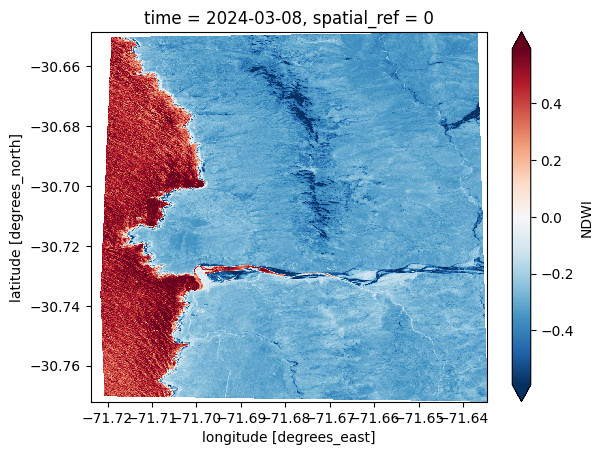

In [100]:
ds.NDWI.plot(robust=True)

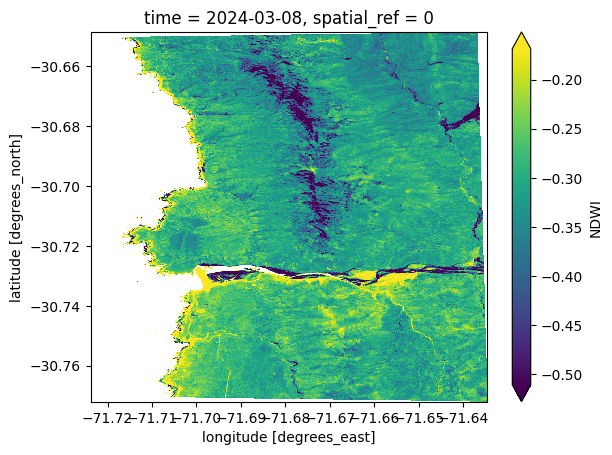

In [101]:

#ds['NDWI_mask'] = ds['NDWI'] > 0.1
ds_masked = ds.where(ds['NDWI'] < 0.1)
ds_masked.NDWI.plot(robust=True)

In [102]:

ds_masked = ds_masked.drop_vars(indicesList)

In [103]:

ras_location ="/content/drive/MyDrive/Programming/Colab Notebooks/Fray Jorge LULC/FrayJorge/input/static.tif"
# Load existing xarray.Dataset (assumed full extent)
ds_base = rioxarray.open_rasterio(ras_location, masked=True).squeeze()
variable_names = list(ds_base.attrs['long_name'])

# Create a dictionary of named DataArrays from each band
data_vars = {
    name: ds_base.sel(band=i+1).drop_vars('band')  # bands are 1-indexed
    for i, name in enumerate(variable_names)
}

# Create a new Dataset from the dictionary
da = xr.Dataset(data_vars)

ds_base = da.drop_vars("rios")
ds_base = ds_base.drop_vars("vial")


In [104]:
# Ensure ds_new has the same CRS
ds_base = ds_base.rio.reproject_match(ds_masked)
ds_base

<xarray.Dataset> Size: 32MB
Dimensions:      (x: 979, y: 1355)
Coordinates:
    spatial_ref  int64 8B 0
  * x            (x) float64 8kB -71.72 -71.72 -71.72 ... -71.63 -71.63 -71.63
  * y            (y) float64 11kB -30.65 -30.65 -30.65 ... -30.77 -30.77 -30.77
Data variables:
    aspect       (y, x) float32 5MB nan nan nan nan nan ... 90.0 90.0 90.0 90.0
    slope        (y, x) float32 5MB nan nan nan nan ... 2.774 2.774 2.22 2.22
    TRI          (y, x) float32 5MB nan nan nan nan ... 1.125 1.125 0.625 0.625
    bio1         (y, x) float32 5MB nan nan nan nan ... 14.74 14.74 14.74 14.74
    bio4         (y, x) float32 5MB nan nan nan nan ... 268.5 268.5 268.6 268.6
    bio15        (y, x) float32 5MB nan nan nan nan ... 131.6 131.6 131.6 131.6

In [109]:
masked_ds_base

<xarray.Dataset> Size: 19kB
Dimensions:      (x: 979, y: 1355)
Coordinates:
  * x            (x) float64 8kB -71.72 -71.72 -71.72 ... -71.63 -71.63 -71.63
  * y            (y) float64 11kB -30.65 -30.65 -30.65 ... -30.77 -30.77 -30.77
    time         <U10 40B '2024-03-08'
    spatial_ref  int64 8B 0
Data variables:
    *empty*
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      ('B2', 'B3', 'B4', 'B8', 'B5', 'B6', 'B7', 'B8A', 'B11', ...

In [110]:
# Create a mask of valid data in ds_new (True where valid)
mask = ~ds_base.isnull()

# Broadcast mask to ds_base shape and dimensions
masked_ds_base = ds_masked.where(mask)

In [111]:
# Convert both to Datasets if they aren’t already
#if isinstance(masked_ds_base, xr.DataArray):
#    masked_ds_base = masked_ds_base.to_dataset(name="base_layer")

#if isinstance(ds_base, xr.DataArray):
#    ds_base = ds_base.to_dataset(name="new_layer")

# Combine them
merged = xr.merge([ds_masked, ds_base])
merged

<xarray.Dataset> Size: 96MB
Dimensions:      (y: 1355, x: 979)
Coordinates:
  * x            (x) float64 8kB -71.72 -71.72 -71.72 ... -71.63 -71.63 -71.63
  * y            (y) float64 11kB -30.65 -30.65 -30.65 ... -30.77 -30.77 -30.77
    time         <U10 40B '2024-03-08'
    spatial_ref  int64 8B 0
Data variables: (12/18)
    B2           (y, x) float32 5MB nan nan nan nan ... 825.0 825.0 795.0 883.0
    B3           (y, x) float32 5MB nan nan nan ... 1.118e+03 1.13e+03 1.204e+03
    B4           (y, x) float32 5MB nan nan nan ... 1.616e+03 1.652e+03
    B8           (y, x) float32 5MB nan nan nan ... 2.118e+03 2.198e+03
    B5           (y, x) float32 5MB nan nan nan ... 1.868e+03 2.087e+03
    B6           (y, x) float32 5MB nan nan nan ... 1.966e+03 2.094e+03
    ...           ...
    aspect       (y, x) float32 5MB nan nan nan nan nan ... 90.0 90.0 90.0 90.0
    slope        (y, x) float32 5MB nan nan nan nan ... 2.774 2.774 2.22 2.22
    TRI          (y, x) float32 5MB nan nan nan nan ... 1.125 1.125 0.625 0.625
    bio1         (y, x) float32 5MB nan nan nan nan ... 14.74 14.74 14.74 14.74
    bio4         (y, x) float32 5MB nan nan nan nan ... 268.5 268.5 268.6 268.6
    bio15        (y, x) float32 5MB nan nan nan nan ... 131.6 131.6 131.6 131.6
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      ('B2', 'B3', 'B4', 'B8', 'B5', 'B6', 'B7', 'B8A', 'B11', ...

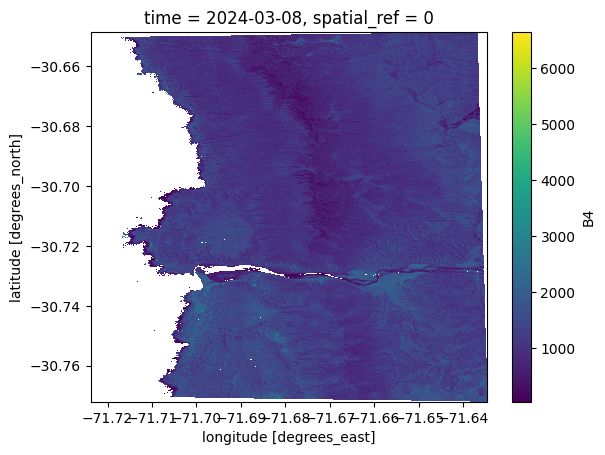

In [118]:
merged.B4.plot()

In [136]:
merged = merged.where(~merged['slope'].isnull())

# Unsupervised Classification of Raster Stacks V0


In [69]:
ds_masked# = data

<xarray.Dataset> Size: 69MB
Dimensions:      (y: 1355, x: 979)
Coordinates:
  * x            (x) float64 8kB -71.72 -71.72 -71.72 ... -71.63 -71.63 -71.63
  * y            (y) float64 11kB -30.65 -30.65 -30.65 ... -30.77 -30.77 -30.77
    time         <U10 40B '2024-03-08'
    spatial_ref  int64 8B 0
Data variables: (12/13)
    B2           (y, x) float32 5MB nan nan nan nan ... 825.0 825.0 795.0 883.0
    B3           (y, x) float32 5MB nan nan nan ... 1.118e+03 1.13e+03 1.204e+03
    B4           (y, x) float32 5MB nan nan nan ... 1.616e+03 1.652e+03
    B8           (y, x) float32 5MB nan nan nan ... 2.118e+03 2.198e+03
    B5           (y, x) float32 5MB nan nan nan ... 1.868e+03 2.087e+03
    B6           (y, x) float32 5MB nan nan nan ... 1.966e+03 2.094e+03
    ...           ...
    B8A          (y, x) float32 5MB nan nan nan ... 2.195e+03 2.385e+03
    B11          (y, x) float32 5MB nan nan nan ... 3.698e+03 3.823e+03
    B12          (y, x) float32 5MB nan nan nan ... 3.623e+03 3.669e+03
    B1           (y, x) float32 5MB nan nan nan nan ... 722.0 722.0 732.0 743.0
    B9           (y, x) float32 5MB nan nan nan ... 2.207e+03 2.237e+03 2.27e+03
    SCL          (y, x) float32 5MB nan nan nan nan nan ... 5.0 5.0 5.0 5.0 5.0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      ('B2', 'B3', 'B4', 'B8', 'B5', 'B6', 'B7', 'B8A', 'B11', ...

## Step 1: Prepare the Data from xarray.Dataset

In [144]:
import numpy as np
import rasterio
from sklearn.preprocessing import StandardScaler

# Reshape the data from (bands, rows, cols) to (pixels, bands)
# Convert to DataArray if needed (assuming bands are variables)
# Stack all bands into a 2D array (samples x features)
data = merged.to_array(dim='band').transpose(..., 'band')  # (..., band) for all spatial dims first

# Flatten spatial dimensions and stack bands
reshaped_data = data.stack(sample=('y', 'x')).transpose('sample', 'band').values

# Remove NaN values if present (common in remote sensing)
valid_mask = ~np.isnan(reshaped_data).any(axis=1)
clean_data = reshaped_data[valid_mask]

# Optionally sample if you have too many pixels
sample_size = min(10000, clean_data.shape[0])
np.random.seed(42)
sample_indices = np.random.choice(clean_data.shape[0], size=sample_size, replace=False)
sample_data = clean_data[sample_indices]

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(sample_data)

## Step 2: Hierarchical Clustering with Dendrogram

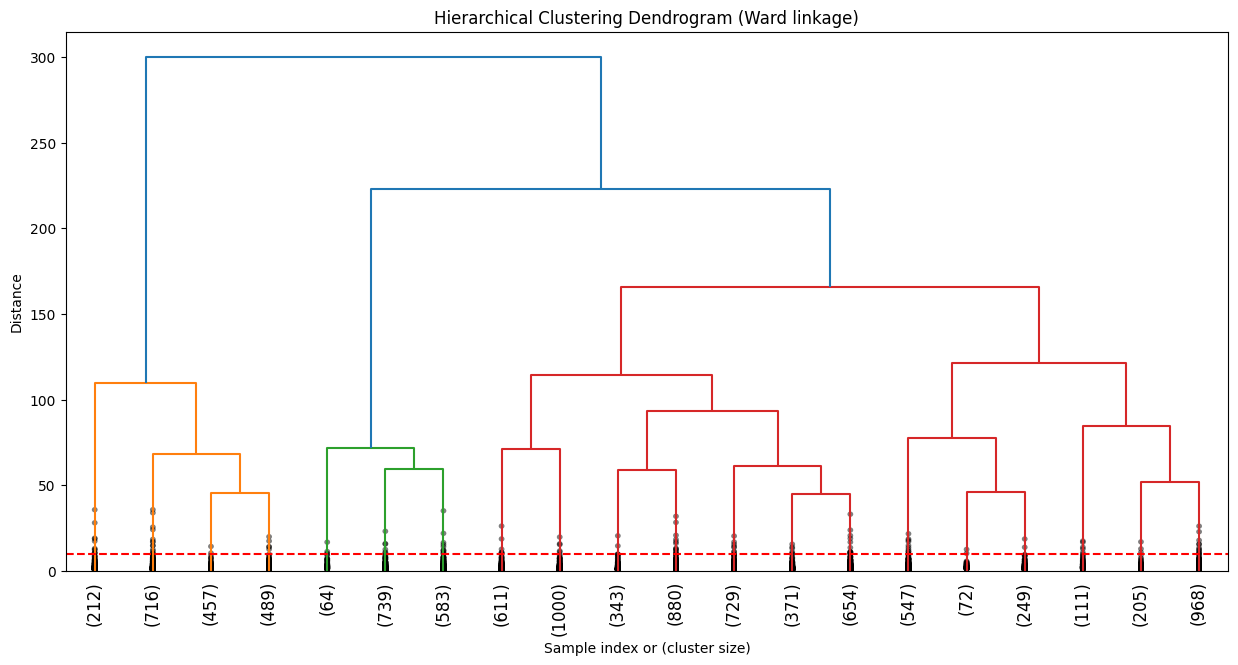

In [145]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt

# Compute linkage matrix
Z = linkage(scaled_data, method='ward', metric='euclidean')

# Plot dendrogram
plt.figure(figsize=(15, 7))
plt.title('Hierarchical Clustering Dendrogram (Ward linkage)')
plt.xlabel('Sample index or (cluster size)')
plt.ylabel('Distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # Show only the last p merged clusters
    p=20,                   # Show last 20 merges
    show_leaf_counts=True,  # Show cluster sizes
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True
)
plt.axhline(y=10, color='r', linestyle='--')  # Example cutoff line
plt.show()

## Step 3: Determine Optimal Number of Clusters

Suggested number of clusters based on dendrogram: 18


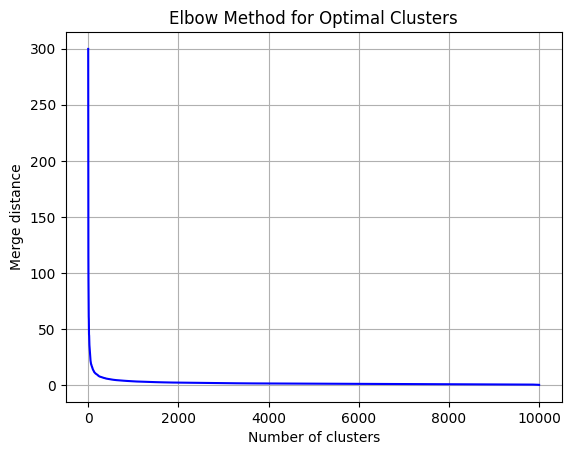

In [146]:
# Calculate the inconsistency coefficient
from scipy.cluster.hierarchy import inconsistent

depth = 5  # How many levels to look below each node
incons = inconsistent(Z, depth)
last_merges = Z[-20:, 2]  # Look at last 20 merges

# Find the largest jump in distance
diff = np.diff(last_merges)
diff_ratio = diff[1:] / diff[:-1]
optimal_n_clusters = len(last_merges) - np.argmax(diff_ratio)

print(f"Suggested number of clusters based on dendrogram: {optimal_n_clusters}")

# Alternatively, use the elbow method on the dendrogram distances
distances = Z[:, 2]
x = range(1, len(distances)+1)
plt.plot(x, distances[::-1], 'b-')
plt.xlabel('Number of clusters')
plt.ylabel('Merge distance')
plt.title('Elbow Method for Optimal Clusters')
plt.grid()
plt.show()

## Step 4: Perform Final Clustering

In [147]:
# Choose number of clusters (adjust based on dendrogram)
n_clusters = optimal_n_clusters  # Example, set based on your analysis

# Get cluster labels for the sample
cluster_labels = fcluster(Z, t=n_clusters, criterion='maxclust')

# For full dataset clustering (memory intensive):
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# First reduce data size for full clustering (optional)
pca = PCA(n_components=0.95)  # Keep 95% variance
reduced_data = pca.fit_transform(scaled_data)

# Perform clustering on reduced data
clusterer = AgglomerativeClustering(
    n_clusters=n_clusters,
    metric='euclidean',
    linkage='ward'
)
cluster_labels = clusterer.fit_predict(reduced_data)

## Step 5: Evaluate Clustering Performance

In [148]:
from sklearn import metrics

# Silhouette Score (higher is better, range [-1, 1])
silhouette = metrics.silhouette_score(scaled_data, cluster_labels)
print(f"Silhouette Score: {silhouette:.3f}")

# Calinski-Harabasz Index (higher is better)
calinski = metrics.calinski_harabasz_score(scaled_data, cluster_labels)
print(f"Calinski-Harabasz Index: {calinski:.3f}")

# Davies-Bouldin Index (lower is better)
davies = metrics.davies_bouldin_score(scaled_data, cluster_labels)
print(f"Davies-Bouldin Index: {davies:.3f}")

# If you have ground truth labels, you can also compute:
# - Adjusted Rand Index
# - Mutual Information
# - Homogeneity, completeness, V-measure

Silhouette Score: 0.142
Calinski-Harabasz Index: 1537.339
Davies-Bouldin Index: 1.559


## Step 6: Visualize Results

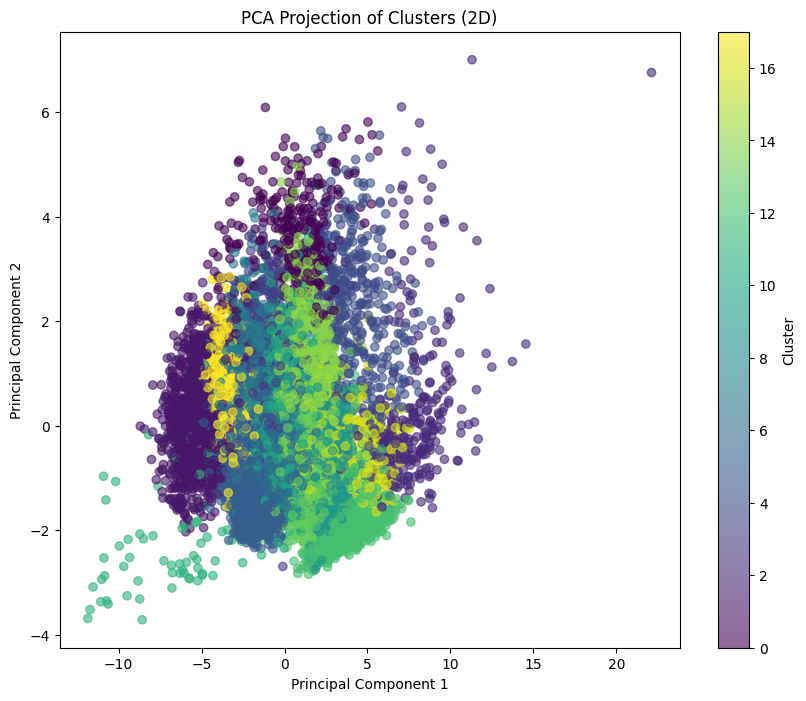

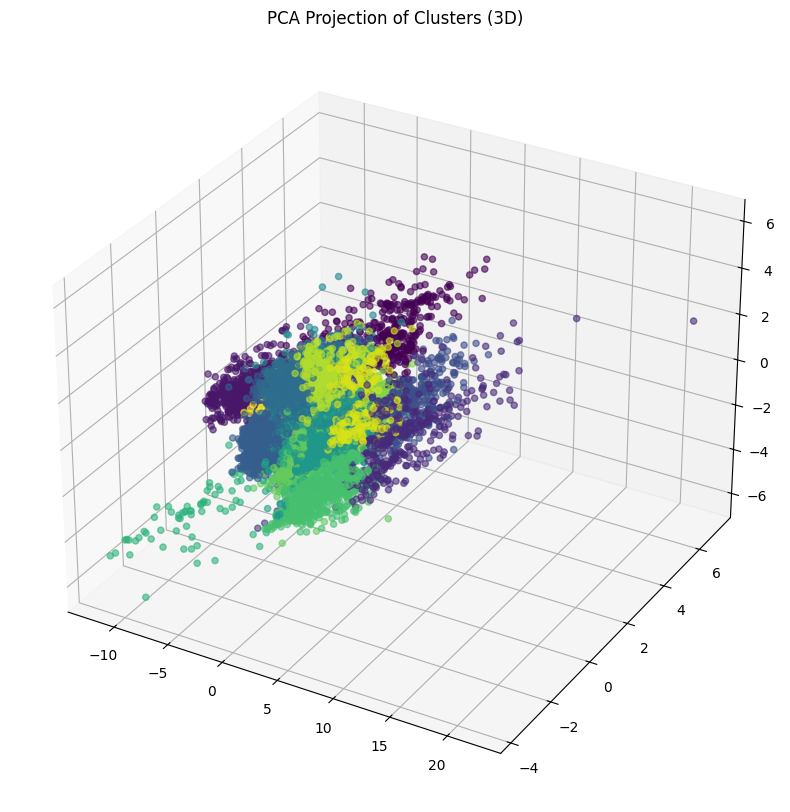

In [149]:
# 2D/3D visualization
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce to 2D or 3D
pca = PCA(n_components=3)
components = pca.fit_transform(scaled_data)

# 2D Plot
plt.figure(figsize=(10, 8))
sc = plt.scatter(components[:, 0], components[:, 1],
                c=cluster_labels, cmap='viridis', alpha=0.6)
plt.colorbar(sc, label='Cluster')
plt.title('PCA Projection of Clusters (2D)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# 3D Plot (optional)
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(components[:, 0], components[:, 1], components[:, 2],
          c=cluster_labels, cmap='viridis', alpha=0.6)
ax.set_title('PCA Projection of Clusters (3D)')
plt.show()

## Step 7: Create xarray Dataset with Cluster Labels

In [150]:
import xarray as xr
# Create full resolution cluster map
full_labels = np.zeros(data.shape[0] * data.shape[1], dtype=np.int16)  # Assuming 2D spatial dims
full_labels[valid_mask.nonzero()[0][sample_indices]] = cluster_labels + 1  # +1 to start at 1
full_labels = full_labels.reshape(data.shape[:2])  # Reshape to original spatial dimensions

# Create xarray DataArray with original coordinates
cluster_da = xr.DataArray(
    full_labels,
    dims=('y', 'x'),  # Adjust to your spatial dim names
    coords={dim: ds[dim] for dim in ('y', 'x')},  # Copy coordinates
    name='cluster_labels'
)

# Add to dataset
ds_clustered = ds.assign(cluster=cluster_da)

# Save results
#ds_clustered.to_netcdf('clustered_results.nc')

In [151]:
ds_clustered = ds.assign(cluster=cluster_da)


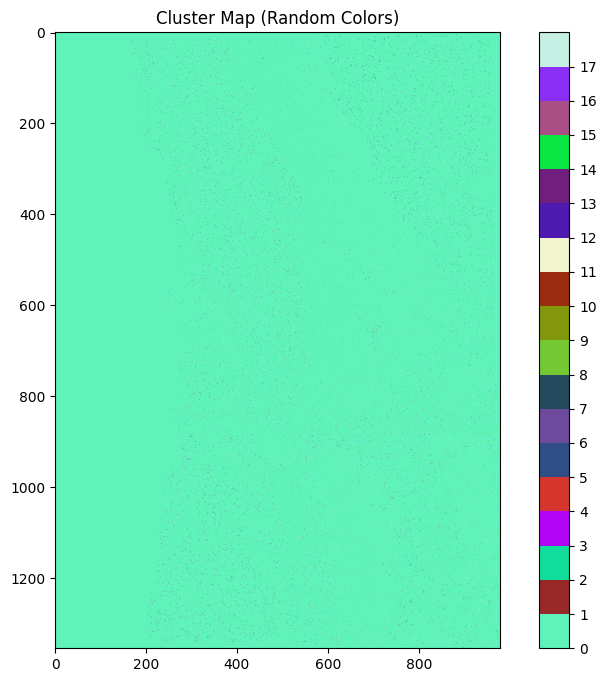

In [152]:

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# Número de clústeres
n_clusters = len(np.unique(cluster_labels))

# Crear un colormap de colores aleatorios
np.random.seed(42)
rand_colors = np.random.rand(n_clusters, 3)
rand_cmap = mcolors.ListedColormap(rand_colors)

# Graficar
plt.figure(figsize=(10, 8))
im = plt.imshow(cluster_da, cmap=rand_cmap)
plt.title('Cluster Map (Random Colors)')
plt.colorbar(im, ticks=np.arange(n_clusters))
plt.show()


## Step 8: Visualize Spatial Clustering (Optional)

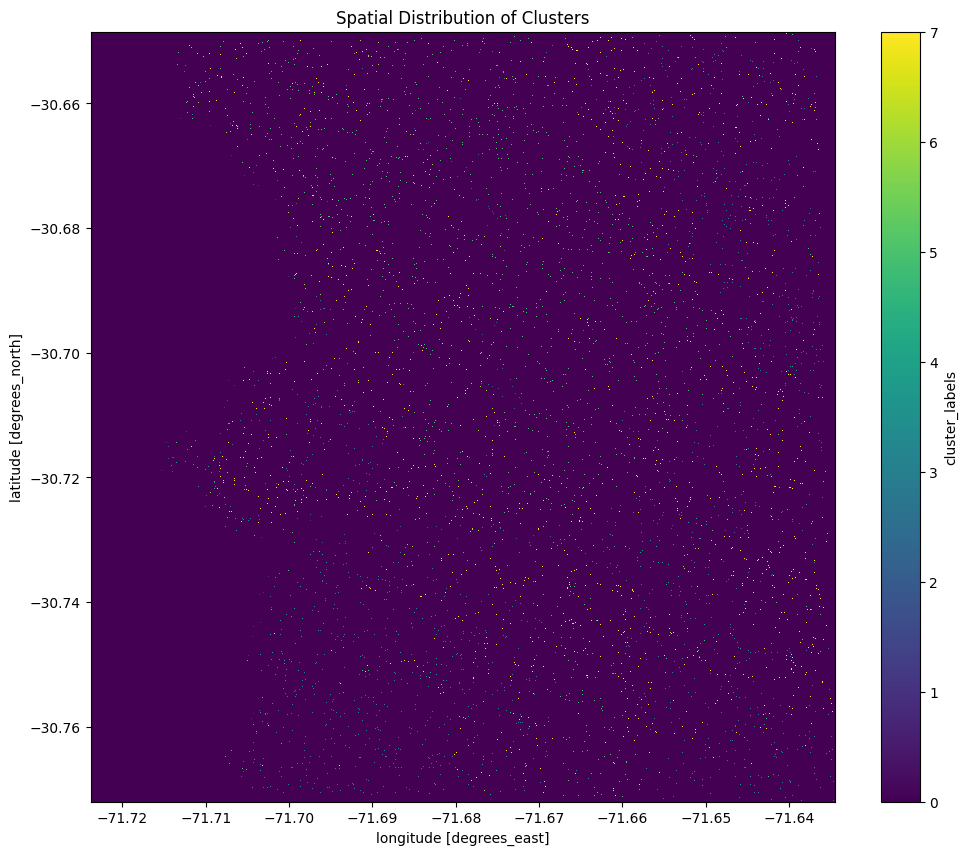

/usr/local/lib/python3.11/dist-packages/xarray/structure/concat.py:540: UserWarning: No index created for dimension cluster because variable cluster is not a coordinate. To create an index for cluster, please first call `.set_coords('cluster')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


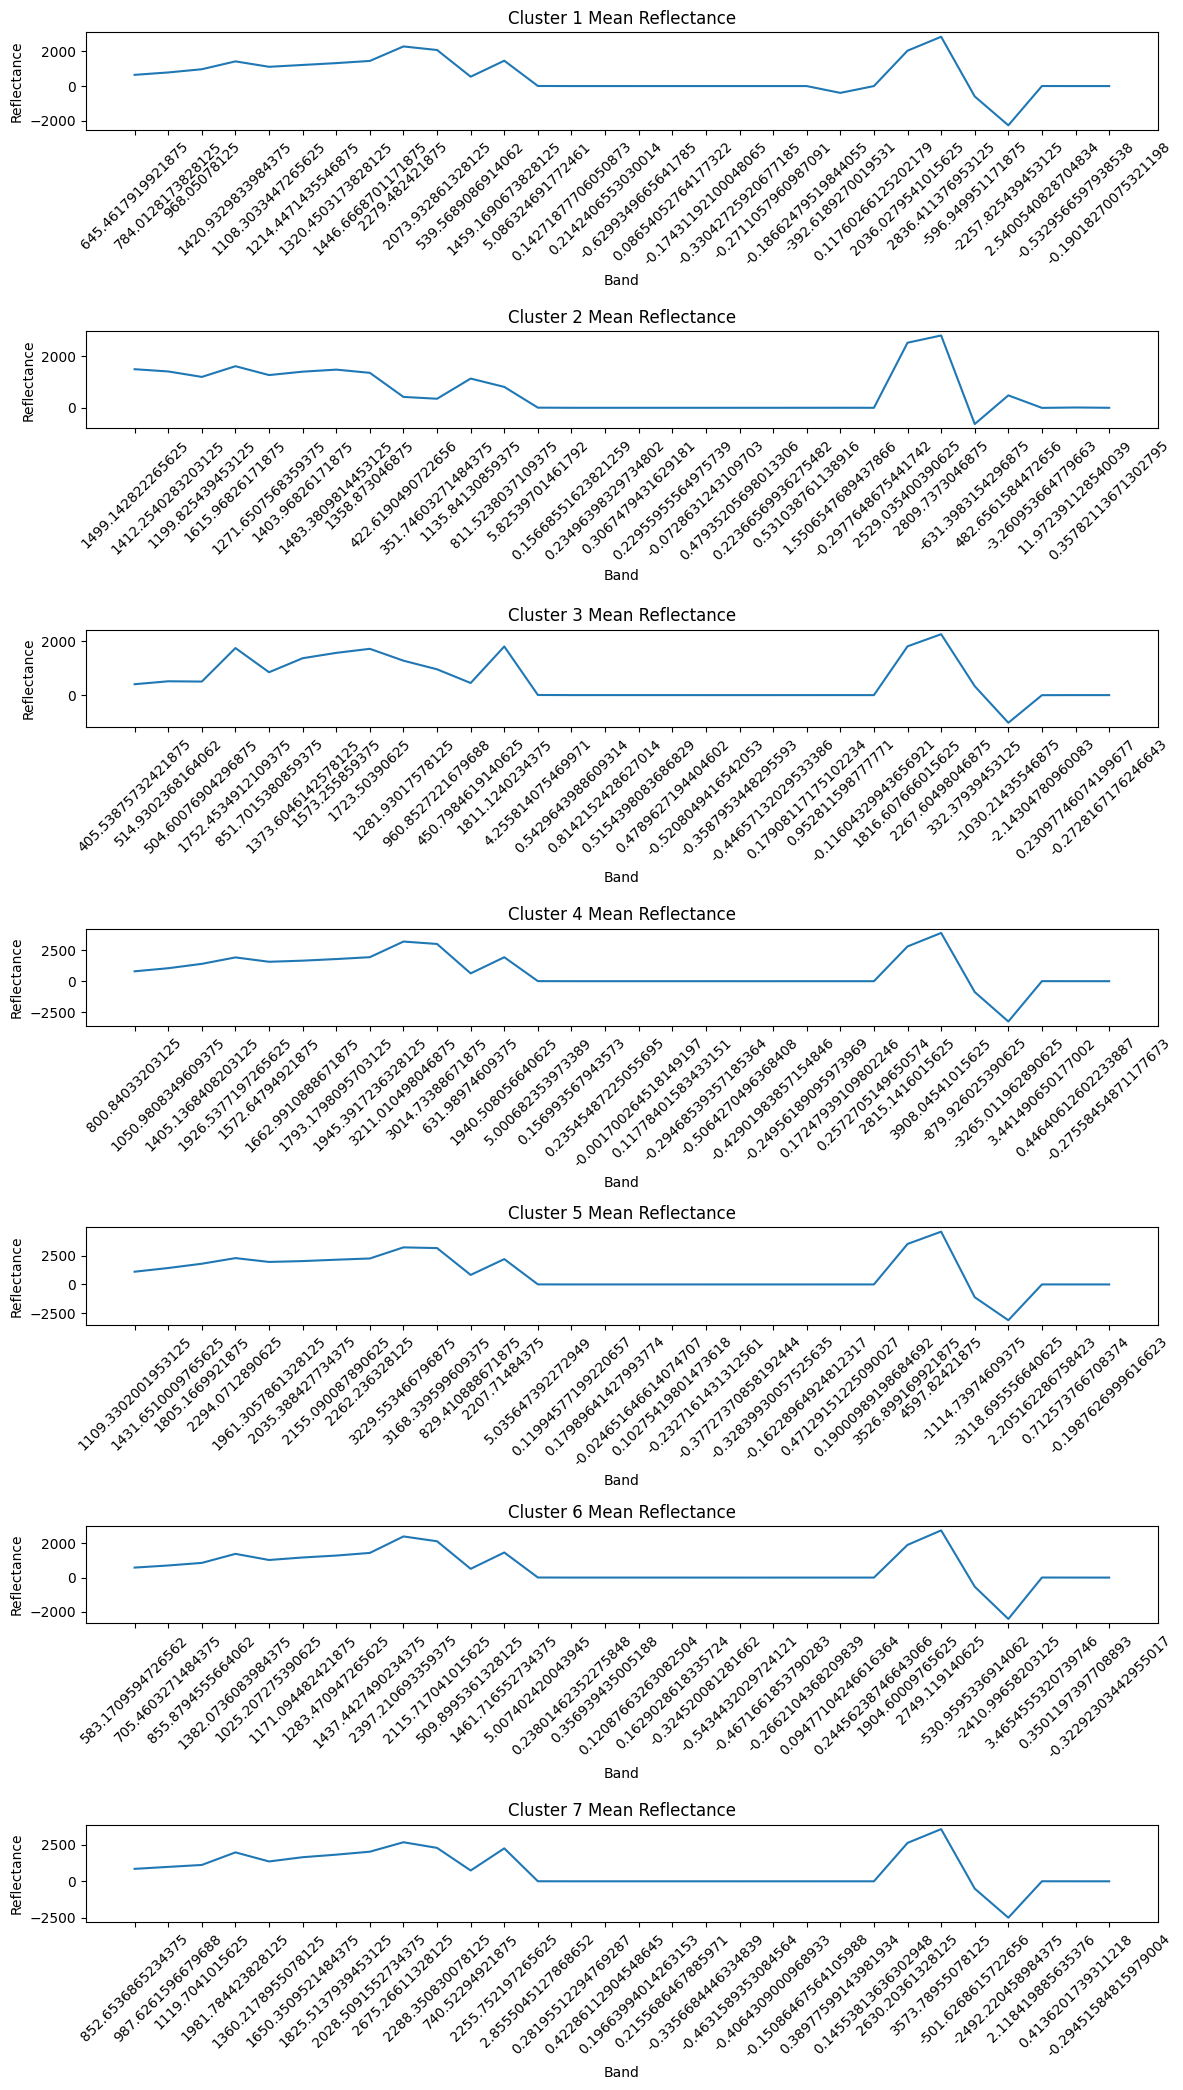

In [22]:
# Plot spatial distribution of clusters
# Plot spatial distribution of clusters
plt.figure(figsize=(12, 10))
cluster_da.plot(cmap='viridis', add_colorbar=True)
plt.title('Spatial Distribution of Clusters')
plt.show()

# Plot mean reflectance per cluster
cluster_means = ds_clustered.groupby('cluster').mean()
bands = [var for var in ds.data_vars if var != 'cluster']  # Obtener nombres de bandas

fig, axes = plt.subplots(n_clusters, 1, figsize=(12, 3 * n_clusters), squeeze=False)

for i, ax in enumerate(axes.flat):
    data = cluster_means.isel(cluster=i)[bands].to_array()
    data.coords['band_index'] = ('variable', np.arange(len(data.variable)))
    data.plot.line(x='band_index', ax=ax)
    ax.set_title(f'Cluster {i+1} Mean Reflectance')
    ax.set_ylabel('Reflectance')
    ax.set_xlabel('Band')
    ax.set_xticks(np.arange(len(data.variable)))
    ax.set_xticklabels(data.variable.values, rotation=45)

plt.tight_layout()
plt.show()



In [ ]:
# Apilar el Dataset y guardar la correspondencia
stacked = ds_masked.to_array(dim='band').stack(sample=('y', 'x')).transpose('sample', 'band')
reshaped_data = stacked.values

# Máscara de valores válidos
valid_mask = ~np.isnan(reshaped_data).any(axis=1)

# Guardar coordenadas para después
sample_coords = stacked['sample']




In [ ]:
# Obtener coordenadas enteras desde el índice MultiIndex
y_idx = sample_coords.to_index().get_level_values('y').values.astype(int)
x_idx = sample_coords.to_index().get_level_values('x').values.astype(int)

# Crear raster 2D vacío
cluster_raster_2d = np.full((ds_masked.sizes['y'], ds_masked.sizes['x']), np.nan)

# Asignar etiquetas en las posiciones correspondientes
cluster_raster_2d[y_idx, x_idx] = cluster_raster

# Convertir a DataArray
cluster_da = xr.DataArray(
    cluster_raster_2d,
    dims=('y', 'x'),
    coords={'y': ds_masked.y, 'x': ds_masked.x},
    name='cluster'
)



IndexError: index 6640575 is out of bounds for axis 0 with size 8020

In [ ]:
cluster_da = xr.DataArray(
    cluster_raster_2d,
    dims=('y', 'x'),
    coords={'y': ds_masked.y, 'x': ds_masked.x},
    name='cluster'
)


**Silhouette Score: 0.283**
Range: -1 to 1 (higher is better)
0.283 indicates:
- Fair clustering quality - Some structure was found but could be improved
- Points are somewhat more similar to their own cluster than to others

- Clusters have moderate separation but likely some overlap

*Actionable Insight:*

- Scores between 0.2-0.5 suggest "weak but potentially interesting" structure
- Consider trying different numbers of clusters or preprocessing methods
- The value suggests your clusters have discernible structure but aren't extremely well-separated

Notes:

- The code preserves the geospatial information from your xarray.Dataset
Memory management is important - the sampling step helps with large datasets
- You can adjust the linkage method ('ward', 'complete', 'average') based on your data
- For very large datasets, consider using dask with xarray for out-of-core computation
- The cluster visualization maintains the spatial relationships in your original data

### (A) PCA (Principal Component Analysis)

In [23]:
from sklearn.decomposition import PCA

# Keep components explaining 95% variance
pca = PCA(n_components=0.95)
reduced_data = pca.fit_transform(scaled_data)
print(f"Original dimensions: {scaled_data.shape[1]}")
print(f"Reduced dimensions: {reduced_data.shape[1]}")

Original dimensions: 30
Reduced dimensions: 6


### (B) MNF (Minimum Noise Fraction) - Ideal for Remote Sensing

In [24]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# MNF is essentially two PCAs:
# 1. PCA on noise-whitened data
# 2. PCA on transformed data
noise_std = np.std(scaled_data - np.mean(scaled_data, axis=0), axis=0)
whitened = scaled_data / noise_std
pca1 = PCA().fit(whitened)
transformed = pca1.transform(whitened)
pca2 = PCA(n_components=0.95).fit(transformed)
reduced_data_mnf = pca2.transform(transformed)

### (C) Band Selection (If You Need Physical Interpretability)

In [25]:
# Select bands with highest variance (example for Sentinel-2)
# Select bands with highest variance (example for Sentinel-2)
high_var_bands = ['B8', 'B11', 'B12']  # NIR, SWIR for vegetation/soil

# Get the list of variable names from the dataset
band_list = list(ds.variables.keys())

# Find the indices of the high_var_bands in the dataset's variable list
band_indices = [band_list.index(b) for b in high_var_bands if b in band_list]

# Select these columns from the scaled data
reduced_data_bands = scaled_data[:, band_indices]


### Performance Comparison Script

In [26]:
import pandas as pd
methods = {
    "Original Data": scaled_data,
    "PCA (95% Var)": PCA(n_components=0.95).fit_transform(scaled_data),
    "MNF Reduction": reduced_data_mnf,  # From MNF example above
    "Selected Bands": reduced_data_bands  # From band selection
}

results = []
for name, data in methods.items():
    Z = linkage(data, method='ward')
    labels = fcluster(Z, t=n_clusters, criterion='maxclust')

    results.append({
        "Method": name,
        "Silhouette": metrics.silhouette_score(data, labels),
        "Calinski-Harabasz": metrics.calinski_harabasz_score(data, labels),
        "Davies-Bouldin": metrics.davies_bouldin_score(data, labels),
        "Dimensions": data.shape[1]
    })

results_df = pd.DataFrame(results)
print(results_df.sort_values("Silhouette", ascending=False))

           Method  Silhouette  Calinski-Harabasz  Davies-Bouldin  Dimensions
3  Selected Bands    0.333301        5000.645020        0.888556           3
2   MNF Reduction    0.218388        2808.291992        1.142184           6
1   PCA (95% Var)    0.218387        2808.295654        1.142185           6
0   Original Data    0.212916        2463.998047        1.287355          30


Data range: -39.083648681640625 to 90.92023468017578
NaN values: 0


Text(0.5, 1.0, 'Band Correlation Matrix')

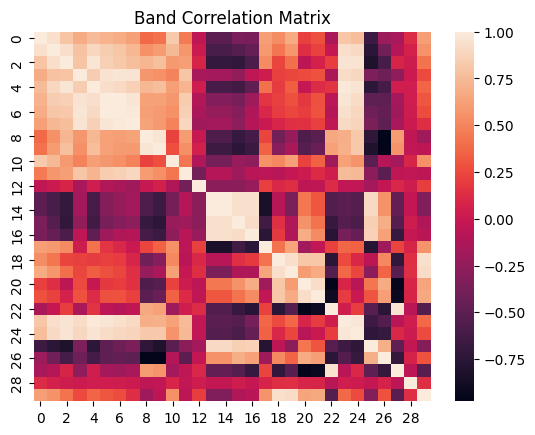

In [27]:
# Check for abnormal values
print(f"Data range: {np.min(scaled_data)} to {np.max(scaled_data)}")
print(f"NaN values: {np.isnan(scaled_data).sum()}")

# Plot band correlations
import seaborn as sns
sns.heatmap(np.corrcoef(scaled_data.T))
plt.title("Band Correlation Matrix")

In [ ]:
# Robust scaling (less sensitive to outliers)
from sklearn.preprocessing import RobustScaler
robust_data = RobustScaler().fit_transform(reshaped_data)

# Logarithmic transform for reflectance
log_data = np.log1p(reshaped_data)  # log(1+x)

ValueError: Input X contains infinity or a value too large for dtype('float32').

In [28]:
from sklearn.cluster import KMeans, DBSCAN

# KMeans with PCA-reduced data
kmeans = KMeans(n_clusters=14, random_state=42).fit(reduced_data_bands)
print(f"KMeans Silhouette: {metrics.silhouette_score(reduced_data_bands, kmeans.labels_)}")

# DBSCAN (for density-based clusters)
dbscan = DBSCAN(eps=0.5, min_samples=10).fit(reduced_data_bands)
print(f"DBSCAN clusters found: {len(np.unique(dbscan.labels_))}")

KMeans Silhouette: 0.33726176619529724
DBSCAN clusters found: 8


In [ ]:
# Add spatial coordinates as features
x_coords, y_coords = np.mgrid[:rows, :cols]
spatial_data = np.c_[scaled_data, x_coords.ravel()/100, y_coords.ravel()/100]  # Scale coordinates

# Cluster with spatial weighting
spatial_labels = AgglomerativeClustering(
    n_clusters=6,
    affinity='euclidean',
    linkage='ward'
).fit_predict(spatial_data)

# Spatial-spectral clustering


In [119]:

#stacked = ds_masked.to_array(dim='band').stack(sample=('y', 'x')).transpose('sample', 'band')
stacked = merged.to_array(dim='band').stack(sample=('y', 'x')).transpose('sample', 'band')
reshaped_data = stacked.values  # shape: (n_pixels, n_bands)
valid_mask = ~np.isnan(reshaped_data).any(axis=1)
clean_data = reshaped_data[valid_mask]  # remove NaNs


In [ ]:
# Detectar valores válidos (sin NaN, inf, ni extremos)
finite_mask = np.all(np.isfinite(clean_data), axis=1) & (np.abs(clean_data).max(axis=1) < 1e6)

# Aplicar máscara
filtered_data = clean_data[finite_mask]
filtered_x = x_coords[finite_mask]
filtered_y = y_coords[finite_mask]


NameError: name 'x_coords' is not defined

In [ ]:
from sklearn.cluster import MiniBatchKMeans

n_clusters = 6
mbk = MiniBatchKMeans(n_clusters=n_clusters, batch_size=1000, random_state=42)
spatial_labels = mbk.fit_predict(spatial_features)


NameError: name 'spatial_features' is not defined

In [ ]:
import numpy as np
import rasterio
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaled_data = scaler.fit_transform(filtered_data)

# Concatenar características espaciales
spatial_features = np.c_[scaled_data, filtered_x / 100, filtered_y / 100]

sample_size = min(10000, spatial_features.shape[0])
sample_idx = np.random.choice(spatial_features.shape[0], sample_size, replace=False)
sample_features = spatial_features[sample_idx]

labels = AgglomerativeClustering(n_clusters=6, linkage='ward').fit_predict(sample_features)



NameError: name 'scaler' is not defined

In [ ]:
# Crear cluster_raster general
cluster_raster_mbk = np.full(spatial_features.shape[0], np.nan)
cluster_raster_mbk[:] = spatial_labels

# Crear cluster_raster para la muestra
cluster_raster_agg = np.full(spatial_features.shape[0], np.nan)
cluster_raster_agg[sample_idx] = labels



In [ ]:
yx = sample_coords.to_index()
y_idx = yx.get_level_values('y').values.astype(int)
x_idx = yx.get_level_values('x').values.astype(int)


In [ ]:
shape_y, shape_x = ds_masked.sizes['y'], ds_masked.sizes['x']

# MiniBatch
raster_mbk = np.full((shape_y, shape_x), np.nan)
raster_mbk[y_idx, x_idx] = cluster_raster_mbk

# Agglomerative
raster_agg = np.full((shape_y, shape_x), np.nan)
raster_agg[y_idx, x_idx] = cluster_raster_agg

cluster_mbk_da = xr.DataArray(raster_mbk, dims=('y', 'x'), coords={'y': ds_masked.y, 'x': ds_masked.x})
cluster_agg_da = xr.DataArray(raster_agg, dims=('y', 'x'), coords={'y': ds_masked.y, 'x': ds_masked.x})


ValueError: shape mismatch: value array of shape (16332587,) could not be broadcast to indexing result of shape (18726700,)

In [ ]:
# Obtener MultiIndex de todos los píxeles válidos
all_coords = stacked['sample'].to_index()
valid_coords = all_coords[valid_mask]

# Coordenadas enteras
y_idx = valid_coords.get_level_values('y').values.astype(int)
x_idx = valid_coords.get_level_values('x').values.astype(int)


In [ ]:
# Para MiniBatchKMeans
raster_mbk = np.full((shape_y, shape_x), np.nan)
raster_mbk[y_idx, x_idx] = cluster_raster_mbk

# Para Agglomerative (solo muestra)
raster_agg = np.full((shape_y, shape_x), np.nan)
raster_agg[y_idx[sample_idx], x_idx[sample_idx]] = cluster_raster_agg[sample_idx]


IndexError: index 6640575 is out of bounds for axis 0 with size 8020

In [30]:
import numpy as np

def coords_to_indices(y_vals, x_vals, y_coords, x_coords):
    """
    Convierte coordenadas espaciales (y, x) en índices de fila y columna válidos para indexar arrays.

    Parameters:
    - y_vals: arreglo 1D con las coordenadas 'y' del DataArray (ej: ds.y.values)
    - x_vals: arreglo 1D con las coordenadas 'x' del DataArray (ej: ds.x.values)
    - y_coords: arreglo 1D de coordenadas 'y' a convertir (de MultiIndex u otro origen)
    - x_coords: arreglo 1D de coordenadas 'x' a convertir

    Returns:
    - y_idx: índices de fila (para axis=0)
    - x_idx: índices de columna (para axis=1)
    """

    # Eje Y: puede estar en orden descendente (típico en raster)
    if y_vals[0] > y_vals[-1]:
        y_vals_flipped = y_vals[::-1]
        y_pos = np.searchsorted(y_vals_flipped, y_coords, side='right') - 1
        y_idx = len(y_vals_flipped) - 1 - y_pos
    else:
        y_idx = np.searchsorted(y_vals, y_coords, side='right') - 1

    # Eje X: ascendente en general
    if x_vals[0] > x_vals[-1]:
        x_vals_flipped = x_vals[::-1]
        x_pos = np.searchsorted(x_vals_flipped, x_coords, side='right') - 1
        x_idx = len(x_vals_flipped) - 1 - x_pos
    else:
        x_idx = np.searchsorted(x_vals, x_coords, side='right') - 1

    return y_idx, x_idx


In [137]:
import numpy as np
import xarray as xr
from sklearn.preprocessing import StandardScaler

# Apilar bandas como (sample, band)
stacked = merged.to_array(dim='band').stack(sample=('y', 'x')).transpose('sample', 'band')
#stacked = ds_masked.to_array(dim='band').stack(sample=('y', 'x')).transpose('sample', 'band')
reshaped_data = stacked.values  # (n_pixels, n_bands)

# Filtrar píxeles válidos
valid_mask = np.all(np.isfinite(reshaped_data), axis=1)
clean_data = reshaped_data[valid_mask]

# Coordenadas (y, x) para cada píxel válido
all_coords = stacked['sample'].to_index()
valid_coords = all_coords[valid_mask]
# Valores originales de las coordenadas espaciales
y_vals = ds_masked.y.values
x_vals = ds_masked.x.values

y_coords = valid_coords.get_level_values('y').values
x_coords = valid_coords.get_level_values('x').values

y_idx, x_idx = coords_to_indices(y_vals, x_vals, y_coords, x_coords)

# Escalar espectralmente
scaler = StandardScaler()
scaled_data = scaler.fit_transform(clean_data)

## Opción 2: escalar todo junto
#combined = np.c_[clean_data, x_coords, y_coords]
#scaled_combined = StandardScaler().fit_transform(combined)

# Añadir coordenadas espaciales (escaladas)
#spatial_features = np.c_[scaled_data, x_idx / 100, y_idx / 100]
spatial_features = np.c_[scaled_data, x_coords / 5000, y_coords / 5000]


In [138]:
inertias = []
K = range(1, 20)  # or any range you want to test

for k in K:
    mbk = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=100)
    mbk.fit(spatial_features)  # X is your input data (array or dataframe)
    inertias.append(mbk.inertia_)


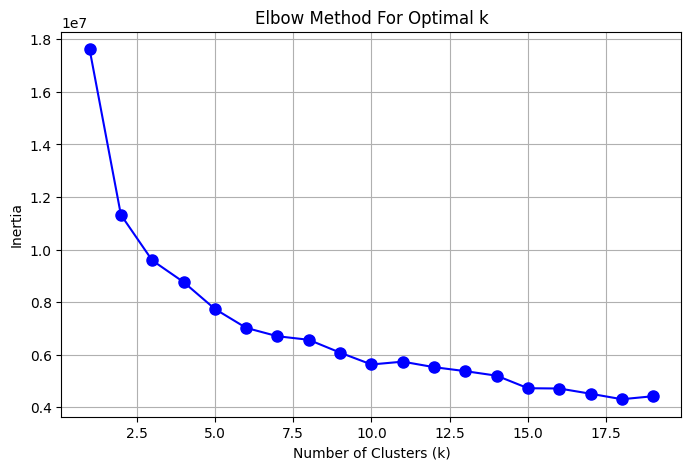

In [139]:
plt.figure(figsize=(8, 5))
plt.plot(K, inertias, 'bo-', markersize=8)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()


Optimal number of clusters based on largest relative drop: 8


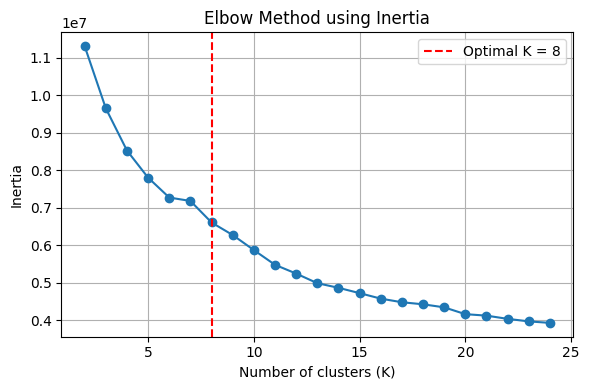

In [154]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans

# Define range of K to test
K = range(2, 25)
inertias = []

# Fit MiniBatchKMeans for each K
for k in K:
    model = MiniBatchKMeans(n_clusters=k, batch_size=1000, random_state=42)
    model.fit(spatial_features)  # Replace X with your data
    inertias.append(model.inertia_)

# Calculate first differences
diffs = np.diff(inertias)

# Compute ratio of drops (similar to jump ratios in dendrogram distances)
diff_ratios = np.array(diffs[1:]) / np.array(diffs[:-1])

# Find largest relative drop (elbow)
# +2: because np.diff shifts indices (-1), and we skip the first ratio (index 0), so add 2
optimal_k = K[np.argmax(diff_ratios) + 2]

print(f"Optimal number of clusters based on largest relative drop: {optimal_k}")

# Optional: plot the "elbow" from inertia
plt.figure(figsize=(6, 4))
plt.plot(K, inertias, marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method using Inertia')
plt.grid(True)
plt.axvline(optimal_k, color='red', linestyle='--', label=f'Optimal K = {optimal_k}')
plt.legend()
plt.tight_layout()
plt.show()




In [155]:
from sklearn.cluster import MiniBatchKMeans, AgglomerativeClustering

n_clusters = optimal_k#7

# MiniBatchKMeans: todos los píxeles válidos
#mbk = MiniBatchKMeans(n_clusters=n_clusters, random_state=42)
mbk = MiniBatchKMeans(
    n_clusters=n_clusters,
    n_init=20,
    batch_size=256,
    max_iter=1000,
    max_no_improvement=20,
    random_state=42
)

mbk_labels = mbk.fit_predict(spatial_features)

# Agglomerative: muestra de 10.000
#sample_size = min(10000, spatial_features.shape[0])
#np.random.seed(42)
#sample_idx = np.random.choice(spatial_features.shape[0], size=sample_size, replace=False)
#sample_features = spatial_features[sample_idx]

#agg = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
#agg_labels = agg.fit_predict(sample_features)


In [156]:
shape_y, shape_x = ds_masked.sizes['y'], ds_masked.sizes['x']

# Raster para MiniBatchKMeans
raster_mbk = np.full((shape_y, shape_x), np.nan)
raster_mbk[y_idx, x_idx] = mbk_labels
cluster_mbk_da = xr.DataArray(raster_mbk, dims=('y', 'x'), coords={'y': ds_masked.y, 'x': ds_masked.x}, name='mbk_cluster')

# Raster para Agglomerative (solo píxeles muestreados)
#raster_agg = np.full((shape_y, shape_x), np.nan)
#raster_agg[y_idx[sample_idx], x_idx[sample_idx]] = agg_labels
#cluster_agg_da = xr.DataArray(raster_agg, dims=('y', 'x'), coords={'y': ds_masked.y, 'x': ds_masked.x}, name='agg_cluster')


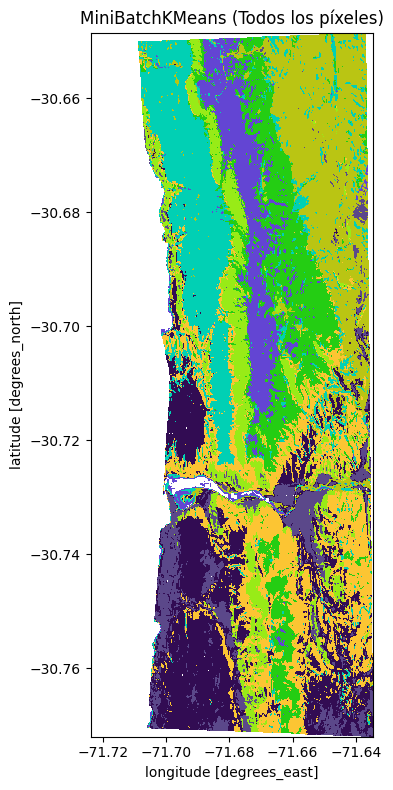

In [157]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

rand_colors = np.random.rand(n_clusters, 3)
cmap = mcolors.ListedColormap(rand_colors)

fig, axs = plt.subplots(1, 1, figsize=(4, 8))

cluster_mbk_da.plot(ax=axs, cmap=cmap, add_colorbar=False)
axs.set_title('MiniBatchKMeans (Todos los píxeles)')

#cluster_agg_da.plot(ax=axs[1], cmap=cmap, add_colorbar=False)
#axs[1].set_title('AgglomerativeClustering (Muestra de 10K)')

plt.tight_layout()
plt.show()


In [36]:
from sklearn.metrics import silhouette_score

labels = mbk.labels_
score = silhouette_score(spatial_features, labels)
print(f'Silhouette Score: {score:.3f}')



KeyboardInterrupt: 

In [38]:
import matplotlib.pyplot as plt

scores = []
inertias = []
k_range = range(2, 15)

for k in k_range:
    mbk = MiniBatchKMeans(n_clusters=k, n_init=20, batch_size=256, random_state=42)
    mbk.fit(spatial_features)
    scores.append(silhouette_score(spatial_features, mbk.labels_))
    inertias.append(mbk.inertia_)

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(k_range, scores, marker='o')
plt.title("Silhouette Score vs. n_clusters")

plt.subplot(1, 2, 2)
plt.plot(k_range, inertias, marker='x')
plt.title("Inertia vs. n_clusters")

plt.tight_layout()
plt.show()


KeyboardInterrupt: 

In [37]:
# Exportar como GeoTIFF con rioxarray
import rioxarray

#cluster_mbk_da.rio.write_crs(ds_masked.rio.crs, inplace=True)
#cluster_agg_da.rio.write_crs(ds_masked.rio.crs, inplace=True)

cluster_mbk_da.rio.to_raster(output_folder+"/clustering_mbk_mask_16.tif")
#cluster_agg_da.rio.to_raster(output_folder+"/clustering_agg.tif")
output_folder

'/content/drive/MyDrive/Programming/Colab Notebooks/Fray Jorge LULC/FrayJorge/output'

# Autoencoders

In [ ]:
X = clean_data.astype('float32')  # TensorFlow requiere float32


### Definir el Autoencoder

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

input_dim = X.shape[1]      # número de bandas
latent_dim = 6              # reducción a 6 dimensiones

# Encoder
input_layer = layers.Input(shape=(input_dim,))
encoded = layers.Dense(64, activation='relu')(input_layer)
encoded = layers.Dense(32, activation='relu')(encoded)
encoded_output = layers.Dense(latent_dim, activation='linear')(encoded)

# Decoder
decoded = layers.Dense(32, activation='relu')(encoded_output)
decoded = layers.Dense(64, activation='relu')(decoded)
decoded_output = layers.Dense(input_dim, activation='linear')(decoded)

# Autoencoder completo
autoencoder = models.Model(inputs=input_layer, outputs=decoded_output)

# Solo el encoder para extracción posterior
encoder = models.Model(inputs=input_layer, outputs=encoded_output)

# Compilar
autoencoder.compile(optimizer='adam', loss='mse')


### Entrenar

In [ ]:
autoencoder.fit(X, X, epochs=50, batch_size=256, shuffle=True, validation_split=0.1)


### Reducir dimensionalidad

In [ ]:
X_latent = encoder.predict(X)  # (n_pixels, latent_dim)


### Clustering sobre espacio latente

In [ ]:
from sklearn.cluster import MiniBatchKMeans

kmeans = MiniBatchKMeans(n_clusters=6, random_state=42)
labels = kmeans.fit_predict(X_latent)


### Opcional: incorporar x e y en clustering después



In [ ]:
X_latent_spatial = np.c_[X_latent, x_coords / 5000, y_coords / 5000]
labels = kmeans.fit_predict(X_latent_spatial)


¿Siguiente nivel?
Si te interesa:

- Convolutional Autoencoders para aprovechar la estructura espacial
- Denoising Autoencoders para reforzar robustez
- Variational Autoencoders (VAE) para modelado probabilístico
- Exportar el encoder y usarlo en nuevas imágenes

## Convolutional Denoising Autoencoder (CAE-DAE) por parches (patch-based)

Procesar la imagen en subventanas (patches) como minibatches para:

Ahorrar memoria (evitar cargar todo el raster)

Aumentar dataset con más variedad espacial

Usar fit() con batches pequeños

In [ ]:
def extract_patches(data, patch_size=64, stride=64):
    """
    Extrae parches (sin NaN) de un xarray.Dataset con dims (band, y, x).
    Retorna un arreglo (N, patch_size, patch_size, bands).
    """
    patches = []
    bands, height, width = data.to_array().shape

    for i in range(0, height - patch_size + 1, stride):
        for j in range(0, width - patch_size + 1, stride):
            patch = data.isel(y=slice(i, i + patch_size), x=slice(j, j + patch_size))
            arr = patch.to_array().transpose('y', 'x', 'band').values  # (H, W, C)
            if np.isnan(arr).any():
                continue
            arr = (arr - arr.min()) / (arr.max() - arr.min() + 1e-6)  # Normalizar 0-1
            patches.append(arr.astype('float32'))

    return np.stack(patches, axis=0)  # (N, H, W, C)


In [ ]:
# generar dataset limpio
patches = extract_patches(ds_masked, patch_size=64, stride=32)
print(patches.shape)  # ej. (3000, 64, 64, 10)


In [ ]:
# Construir el CAE-DAE
from tensorflow.keras import layers, models

input_shape = patches.shape[1:]

input_layer = layers.Input(shape=input_shape)

# Encoder
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(input_shape[-1], (3, 3), activation='sigmoid', padding='same')(x)

# Modelo completo
cae_dae = models.Model(input_layer, decoded)
cae_dae.compile(optimizer='adam', loss='mse')


In [ ]:
# Agregar ruido (denoising)
noise_factor = 0.1
patches_noisy = patches + noise_factor * np.random.normal(0, 1, size=patches.shape)
patches_noisy = np.clip(patches_noisy, 0., 1.)



In [ ]:
# Entrenar
cae_dae.fit(patches_noisy, patches, epochs=50, batch_size=32, shuffle=True, validation_split=0.1)


In [ ]:
# Extraer representación latente para clustering
encoder_model = models.Model(inputs=input_layer, outputs=encoded)

# (N, H/4, W/4, C_latent)
latent_features = encoder_model.predict(patches_noisy)

# Aplanar para clustering
X_latent = latent_features.reshape(latent_features.shape[0], -1)


In [ ]:
# Clustering (ejemplo con KMeans)
from sklearn.cluster import MiniBatchKMeans

kmeans = MiniBatchKMeans(n_clusters=6, random_state=42)
labels = kmeans.fit_predict(X_latent)


### 1. Soft Clustering (Fuzzy Methods)

In [ ]:
from sklearn.mixture import GaussianMixture

# Fuzzy clustering with uncertainty estimates
gmm = GaussianMixture(n_components=6, covariance_type='full')
gmm.fit(scaled_data)
probs = gmm.predict_proba(scaled_data)  # Membership probabilities

# Visualize uncertainty
plt.imshow(probs.reshape(rows, cols, 6)[..., :3])  # Show first 3 clusters as RGB
plt.colorbar(label='Membership Probability')

NameError: name 'rows' is not defined

### 2. Spectral Unmixing (Linear Mixture Modeling)

In [ ]:
from sklearn.decomposition import NMF

# Assume you know approximate endmember count
n_endmembers = 4
model = NMF(n_components=n_endmembers)
abundances = model.fit_transform(scaled_data)  # Proportion of each endmember

# Reshape to spatial dimensions
abundance_maps = abundances.reshape(rows, cols, n_endmembers)

### 3. Spatial-Spectral Segmentation

In [ ]:
from skimage.segmentation import slic

# Convert to image format (assuming 3 selected bands)
image_data = scaled_data[:, :3].reshape(rows, cols, 3)

# SLIC superpixels with spatial continuity
segments = slic(image_data, n_segments=100, compactness=10)
plt.imshow(segments, cmap='tab20')

### 4. Topographic Position Analysis


In [ ]:
from scipy.ndimage import gaussian_filter

# Create topographic position index from PC1
pc1 = reduced_data[:, 0].reshape(rows, cols)
tpi = pc1 - gaussian_filter(pc1, sigma=5)

# Classify continuous gradient
classes = np.digitize(tpi, bins=[-1, -0.5, 0, 0.5, 1])

### 5. Gradient-Boosted Clustering

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# Create pseudo-labels from existing clusters
X_train, X_test, y_train, y_test = train_test_split(
    scaled_data,
    cluster_labels,
    test_size=0.2
)

# Train gradient boosted classifier
model = XGBClassifier()
model.fit(X_train, y_train)
prob_preds = model.predict_proba(scaled_data)  # Continuous predictions

### 6. Continuous Representation (UMAP + Kernel Density)

In [ ]:
import umap
from scipy.stats import gaussian_kde

# Learn continuous manifold
embedding = umap.UMAP(n_components=2).fit_transform(scaled_data)

# Estimate probability density
kde = gaussian_kde(embedding.T)
density = kde(embedding.T)

# Visualize as heatmap
plt.scatter(embedding[:, 0], embedding[:, 1], c=density, cmap='viridis')

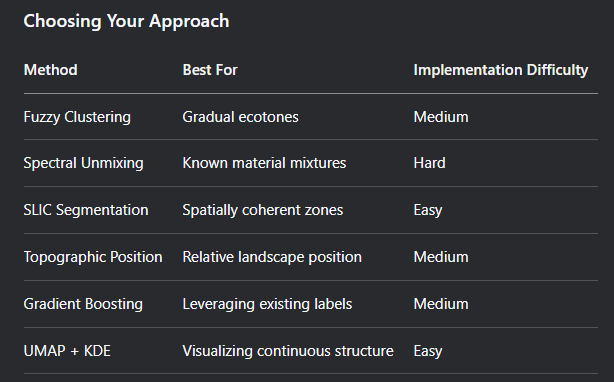

For immediate improvement:

Start with SLIC segmentation if spatial continuity matters

Use fuzzy clustering if you need uncertainty estimates

Try UMAP visualization to understand gradient structure

In [ ]:
# Quick SLIC implementation
segments = slic(
    image_data,
    n_segments=50,          # Adjust for desired granularity
    compactness=20,         # Balance color vs space (10-30 typical)
    sigma=1,                # Smoothing
    start_label=1
)

# Unsupervised Classification of Raster Stacks V1


In [ ]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from sklearn.cluster import (KMeans, MiniBatchKMeans, DBSCAN,
                           AgglomerativeClustering, SpectralClustering)
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import pandas as pd # Import pandas for DataFrame creation

# Load your raster stack (example structure)
# ds = xr.open_dataset('your_raster_stack.nc')
# Let's assume ds has dimensions (time, y, x) and multiple variables

# 1. Data Preparation
def prepare_data(ds):
    """Convert xarray Dataset to 2D array for clustering"""
    # Stack all variables and time steps
    data = ds.to_array().values  # (variables, time, y, x)
    # Reshape to (n_samples, n_features)
    # Use .size for potential NaN/inf handling in future steps
    n_samples = data.shape[2] * data.shape[3]  # y * x
    n_features = data.shape[0] * data.shape[1]  # variables * time
    return data.reshape(n_features, -1).T  # (n_samples, n_features)

X = prepare_data(data)

# 2. Dimensionality Reduction (optional but recommended)
scaler = StandardScaler()

# --- Suggested Change: Handle non-finite values before scaling ---
# Identify rows with NaN or Inf values
non_finite_mask = ~np.isfinite(X).all(axis=1)

# Store original shape for reshaping later
original_shape = (data.y.size, data.x.size)

# Remove rows with non-finite values
X_filtered = X[~non_finite_mask]

# Now fit and transform the filtered data
X_scaled = scaler.fit_transform(X_filtered)
# ---------------------------------------------------------------

pca = PCA(n_components=0.95)  # Keep 95% variance
X_pca = pca.fit_transform(X_scaled)


# 3. Define Clustering Models to Evaluate
models = {
    'KMeans (k=5)': KMeans(n_clusters=5, random_state=42, n_init=10), # Added n_init to suppress future warnings
    'MiniBatchKMeans (k=5)': MiniBatchKMeans(n_clusters=5, random_state=42, n_init=10), # Added n_init
    'DBSCAN (eps=0.5)': DBSCAN(eps=0.5, min_samples=5),
    'Agglomerative (k=5)': AgglomerativeClustering(n_clusters=5),
    # Note: SpectralClustering can be very slow and memory-intensive on large datasets.
    # Consider commenting it out if performance is an issue or if you encounter memory errors.
    # 'Spectral (k=5)': SpectralClustering(n_clusters=5, random_state=42, assign_labels='discretize') # Added assign_labels
}

# 4. Evaluate Models
results = []
cluster_maps = {}

# Create a temporary full labels array to fill in results
# Initialize with a value indicating filtered pixels (e.g., -2)
full_labels = np.full(X.shape[0], -2, dtype=int)

for name, model in models.items():
    print(f"Running {name}...")

    # Fit model
    # Use X_pca for most models, X_scaled might be needed for some like Spectral (though commented out above)
    input_data = X_pca

    # Handle Spectral clustering if you decide to include it
    # if 'Spectral' in name:
    #     # Spectral clustering needs affinity matrix, often computed from scaled data
    #     # For large datasets, this is the main bottleneck. Consider using a subset
    #     # or a different method if data is very large.
    #     # If you use X_pca, the affinity matrix is computed from PCA components.
    #     # Ensure X_pca or X_scaled is used consistently based on model requirements.
    #     input_data = X_scaled # Example if Spectral needs original scaled features

    # Predict labels on the filtered data
    labels = model.fit_predict(input_data)

    # Skip metrics for DBSCAN if too many noise points (-1)
    if isinstance(model, DBSCAN) and (labels == -1).mean() > 0.9: # Increased threshold for skipping
        print(f"Skipping metrics for {name} - too many noise points")
        # Store labels including noise for visualization
        full_labels[~non_finite_mask] = labels
        cluster_maps[name] = full_labels.reshape(original_shape)
        continue


    # Calculate metrics (only if more than one cluster found on filtered data)
    unique_labels_filtered = np.unique(labels[labels != -1]) # Exclude DBSCAN noise from count
    if len(unique_labels_filtered) > 1:
         # Calculate metrics on the filtered data and predicted labels (excluding DBSCAN noise if applicable)
        if isinstance(model, DBSCAN):
             metric_mask = labels != -1
             if np.sum(metric_mask) > 0: # Ensure there are points left after removing noise
                 metrics = {
                     'Model': name,
                     'Silhouette': silhouette_score(input_data[metric_mask], labels[metric_mask]),
                     'Calinski-Harabasz': calinski_harabasz_score(input_data[metric_mask], labels[metric_mask]),
                     'Davies-Bouldin': davies_bouldin_score(input_data[metric_mask], labels[metric_mask]),
                     'n_clusters': len(unique_labels_filtered)
                 }
                 results.append(metrics)
             else:
                  print(f"Skipping metrics for {name} - no non-noise points for evaluation")
        else:
            metrics = {
                'Model': name,
                'Silhouette': silhouette_score(input_data, labels),
                'Calinski-Harabasz': calinski_harabasz_score(input_data, labels),
                'Davies-Bouldin': davies_bouldin_score(input_data, labels),
                'n_clusters': len(unique_labels_filtered) # Use unique_labels_filtered for n_clusters
            }
            results.append(metrics)

    # Store labels for visualization
    # Map the predicted labels back to the original full grid, placing -1 (or -2) in filtered out pixels
    full_labels_copy = np.full(X.shape[0], -2, dtype=int) # Use -2 for originally filtered
    full_labels_copy[~non_finite_mask] = labels
    cluster_maps[name] = full_labels_copy.reshape(original_shape)


# 5. Performance Comparison
# Ensure results_df is created even if no models completed successfully
results_df = pd.DataFrame(results).set_index('Model')

if not results_df.empty:
    print("\nPerformance Metrics:")
    print(results_df)

    # Plot metrics
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    for i, metric in enumerate(['Silhouette', 'Calinski-Harabasz', 'Davies-Bouldin']):
        if metric in results_df.columns:
            sns.barplot(data=results_df.reset_index(), x='Model', y=metric, ax=axes[i])
            axes[i].set_title(metric)
            axes[i].tick_params(axis='x', rotation=45)
        else:
             axes[i].set_title(f"{metric} - No data") # Handle case where metric column doesn't exist
    plt.tight_layout()
    plt.show()
else:
    print("\nNo clustering models evaluated successfully to display performance metrics.")


# 6. Visualize Cluster Maps
n_models = len(cluster_maps)
if n_models > 0:
    fig, axes = plt.subplots(1, n_models, figsize=(5*n_models, 5))
    if n_models == 1:
        axes = [axes]

    for ax, (name, labels) in zip(axes, cluster_maps.items()):
        # Use a colormap that handles negative values differently (e.g., white or grey for -2)
        # You might need a custom colormap or handle the -2 value explicitly
        # For simplicity, using a standard colormap, -2 will likely map to a distinct color
        im = ax.imshow(labels, cmap='viridis')
        ax.set_title(name)
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()
else:
    print("\nNo cluster maps generated.")


# 7. Optimal Cluster Number Analysis (for KMeans)
# Perform this analysis on the filtered data
if 'KMeans (k=5)' in models and X_pca.shape[0] > 0: # Ensure X_pca is not empty
    silhouette_scores = []
    calinski_scores = []
    k_values = range(2, min(11, X_pca.shape[0])) # Ensure k is less than number of samples

    if len(k_values) >= 2: # Need at least 2 values to plot
        for k in k_values:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) # Added n_init
            labels = kmeans.fit_predict(X_pca)
            if len(np.unique(labels)) > 1: # Ensure more than one cluster for metrics
                silhouette_scores.append(silhouette_score(X_pca, labels))
                calinski_scores.append(calinski_harabasz_score(X_pca, labels))
            else:
                 # Append NaN or continue if only one cluster is found
                 silhouette_scores.append(np.nan)
                 calinski_scores.append(np.nan)


        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        ax1.plot(k_values, silhouette_scores, 'bo-')
        ax1.set_xlabel('Number of clusters')
        ax1.set_ylabel('Silhouette Score')
        ax1.set_title('Silhouette Method')
        ax1.set_xticks(k_values) # Ensure all k values are shown on the x-axis

        ax2.plot(k_values, calinski_scores, 'go-')
        ax2.set_xlabel('Number of clusters')
        ax2.set_ylabel('Calinski-Harabasz Score')
        ax2.set_title('Variance Ratio Method')
        ax2.set_xticks(k_values) # Ensure all k values are shown on the x-axis

        plt.tight_layout()
        plt.show()
    else:
        print("\nNot enough data points to perform optimal cluster number analysis for KMeans.")

else:
    print("\nKMeans model not evaluated or insufficient data for optimal cluster number analysis.")

Running KMeans (k=5)...


In [ ]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from sklearn.cluster import (KMeans, MiniBatchKMeans, DBSCAN,
                           AgglomerativeClustering, SpectralClustering)
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Load your raster stack (example structure)
# ds = xr.open_dataset('your_raster_stack.nc')
# Let's assume ds has dimensions (time, y, x) and multiple variables

# 1. Data Preparation
def prepare_data(ds):
    """Convert xarray Dataset to 2D array for clustering"""
    # Stack all variables and time steps
    data = ds.to_array().values  # (variables, time, y, x)
    # Reshape to (n_samples, n_features)
    n_samples = data.shape[2] * data.shape[3]  # y * x
    n_features = data.shape[0] * data.shape[1]  # variables * time
    return data.reshape(n_features, -1).T  # (n_samples, n_features)

X = prepare_data(data)


In [ ]:
X

array([[ 2.3800000e+02,  1.2800000e+02,  8.2000000e+01, ...,
        -2.2086304e-02, -7.3974910e+00,  1.7773019e-01],
       [ 2.3300000e+02,  1.3000000e+02,  1.0200000e+02, ...,
        -2.9704429e-02, -6.5516782e+00,  2.1900827e-01],
       [ 2.4900000e+02,  1.3400000e+02,  9.6000000e+01, ...,
        -1.8371172e-01, -7.7218204e+00,  2.3240939e-01],
       ...,
       [ 6.6800000e+02,  9.5400000e+02,  1.5600000e+03, ...,
         3.1420240e+00,  3.4885594e-01, -3.0559319e-01],
       [ 6.1400000e+02,  8.8400000e+02,  1.4260000e+03, ...,
         3.7285748e+00,  3.1026155e-01, -3.2290241e-01],
       [ 6.3100000e+02,  9.0000000e+02,  1.4500000e+03, ...,
         3.6161795e+00,  3.3709466e-01, -3.1588665e-01]], dtype=float32)

In [ ]:
# 2. Dimensionality Reduction (optional but recommended)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=0.95)  # Keep 95% variance
X_pca = pca.fit_transform(X_scaled)



ValueError: Input X contains infinity or a value too large for dtype('float32').

In [ ]:
# 3. Define Clustering Models to Evaluate
models = {
    'KMeans (k=5)': KMeans(n_clusters=5, random_state=42),
    'MiniBatchKMeans (k=5)': MiniBatchKMeans(n_clusters=5, random_state=42),
    'DBSCAN (eps=0.5)': DBSCAN(eps=0.5, min_samples=5),
    'Agglomerative (k=5)': AgglomerativeClustering(n_clusters=5),
    'Spectral (k=5)': SpectralClustering(n_clusters=5, random_state=42)
}


In [ ]:
# 4. Evaluate Models
results = []
cluster_maps = {}

for name, model in models.items():
    print(f"Running {name}...")

    # Fit model
    labels = model.fit_predict(X_pca if 'Spectral' not in name else X_scaled)

    # Skip metrics for DBSCAN if too many noise points
    if isinstance(model, DBSCAN) and (labels == -1).mean() > 0.5:
        print(f"Skipping {name} - too many noise points")
        continue

    # Calculate metrics (only if not all noise)
    if len(np.unique(labels)) > 1:
        metrics = {
            'Model': name,
            'Silhouette': silhouette_score(X_pca, labels),
            'Calinski-Harabasz': calinski_harabasz_score(X_pca, labels),
            'Davies-Bouldin': davies_bouldin_score(X_pca, labels),
            'n_clusters': len(np.unique(labels))
        }
        results.append(metrics)

    # Store labels for visualization
    cluster_maps[name] = labels.reshape(ds.dims['y'], ds.dims['x'])



In [ ]:
# 5. Performance Comparison
results_df = pd.DataFrame(results).set_index('Model')
print("\nPerformance Metrics:")
print(results_df)

# Plot metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, metric in enumerate(['Silhouette', 'Calinski-Harabasz', 'Davies-Bouldin']):
    sns.barplot(data=results_df.reset_index(), x='Model', y=metric, ax=axes[i])
    axes[i].set_title(metric)
    axes[i].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

# 6. Visualize Cluster Maps
n_models = len(cluster_maps)
fig, axes = plt.subplots(1, n_models, figsize=(5*n_models, 5))
if n_models == 1:
    axes = [axes]

for ax, (name, labels) in zip(axes, cluster_maps.items()):
    im = ax.imshow(labels, cmap='viridis')
    ax.set_title(name)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

# 7. Optimal Cluster Number Analysis (for KMeans)
if 'KMeans (k=5)' in models:
    silhouette_scores = []
    calinski_scores = []
    k_values = range(2, 11)

    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X_pca)
        silhouette_scores.append(silhouette_score(X_pca, labels))
        calinski_scores.append(calinski_harabasz_score(X_pca, labels))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.plot(k_values, silhouette_scores, 'bo-')
    ax1.set_xlabel('Number of clusters')
    ax1.set_ylabel('Silhouette Score')
    ax1.set_title('Silhouette Method')

    ax2.plot(k_values, calinski_scores, 'go-')
    ax2.set_xlabel('Number of clusters')
    ax2.set_ylabel('Calinski-Harabasz Score')
    ax2.set_title('Variance Ratio Method')
    plt.tight_layout()
    plt.show()

Key Components:
* Data Preparation:

  - Converts xarray Dataset to 2D array (pixels × features)
  - Handles multiple variables and time steps

* Dimensionality Reduction:

  - Standard scaling for normalization

  - PCA to reduce computational complexity

* Model Architectures:

  - KMeans: Classic centroid-based clustering

  - MiniBatchKMeans: Faster version for large datasets

  - DBSCAN: Density-based clustering

  - Agglomerative: Hierarchical clustering

  - Spectral: Graph-based clustering

* Performance Metrics:

  - Silhouette Score (-1 to 1, higher is better)

  - Calinski-Harabasz (higher is better)

  - Davies-Bouldin (lower is better)

* Visualization:

  - Cluster maps for spatial patterns

  - Metric comparison bar plots

  - Elbow plots for optimal cluster number

##Alternative Model Options:




1.   Gaussian Mixture Models:



In [ ]:
from sklearn.mixture import GaussianMixture
models['GMM (k=5)'] = GaussianMixture(n_components=5, random_state=42)

2. HDBSCAN (improved density-based):

In [ ]:
from hdbscan import HDBSCAN
models['HDBSCAN'] = HDBSCAN(min_cluster_size=5)

3. Self-Organizing Maps:

In [ ]:
from minisom import MiniSom
som = MiniSom(5, 5, X_pca.shape[1], sigma=0.5, learning_rate=0.5)
som.train_random(X_pca, 100)

##Performance Optimization Tips:
* For large rasters:

  - Use MiniBatchKMeans or subsample

  - Reduce PCA components

  - Process in chunks

* For better spatial coherence:

  - Include spatial coordinates as features

  - Use SpatialKMeans from sklearn-extensions

* For temporal patterns:

  - Extract temporal features before clustering

  - Use TimeSeriesKMeans from tslearn

This framework provides a complete pipeline from data preparation to model evaluation, with multiple visualization options to interpret the results. The choice of best model depends on your specific data characteristics and application requirements.

## Unsupervised Model Comparison Summary

# Unsupervised Classification Models Comparison

| Model               | Pros                                                                 | Cons                                                                 | Best For                                  |
|---------------------|----------------------------------------------------------------------|----------------------------------------------------------------------|-------------------------------------------|
| **KMeans**          | ✅ Fast computation<br>✅ Scalable to large data<br>✅ Guaranteed convergence | ❌ Requires predefined *k*<br>❌ Sensitive to initialization<br>❌ Assumes spherical clusters | Homogeneous landscapes with clear spectral separation |
| **MiniBatchKMeans** | ✅ Faster than KMeans for large datasets<br>✅ Memory-efficient       | ❌ Slightly lower accuracy<br>❌ Same limitations as KMeans          | Large raster stacks (>1M pixels)          |
| **DBSCAN**          | ✅ No need to specify *k*<br>✅ Handles irregular shapes<br>✅ Identifies noise | ❌ Sensitive to parameters (*eps*, *min_samples*)<br>❌ Struggles with varying densities | Heterogeneous landscapes with natural clusters |
| **Agglomerative**   | ✅ Hierarchical structure<br>✅ Flexible distance metrics<br>✅ Visualizable dendrograms | ❌ Computationally expensive (O(n³))<br>❌ Memory-intensive | Small datasets with hierarchical patterns |
| **Spectral**        | ✅ Captures complex structures<br>✅ Works with non-convex shapes     | ❌ Requires affinity matrix (memory-heavy)<br>❌ Slow for large datasets | High-dimensional data with non-linear patterns |
| **GMM**             | ✅ Soft clustering (probabilities)<br>✅ Flexible cluster shapes      | ❌ Sensitive to initialization<br>❌ Assumes Gaussian distributions  | Probabilistic classification needs        |


### **Key Evaluation Metrics**
| Metric               | Range          | Interpretation                          |
|----------------------|----------------|-----------------------------------------|
| **Silhouette Score** | -1 to 1        | Higher = Better separation              |
| **Calinski-Harabasz**| 0 to ∞         | Higher = Better defined clusters        |
| **Davies-Bouldin**   | 0 to ∞         | Lower = Better cluster separation       |


*Practical Recommendations*

For large datasets:

* Start with MiniBatchKMeans (speed) or HDBSCAN (auto-clustering)

For noisy data:

* Use DBSCAN or HDBSCAN to filter noise

For hierarchical patterns:

* Agglomerative Clustering with linkage plots

When k is unknown:

* Run KMeans with elbow/silhouette analysis first

For spatial coherence:

* Add XY coordinates as features or use SpatialKMeans

## Visualization Workflow

In [ ]:
# PCA Scatter Plot:
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap='viridis', s=1)

In [ ]:
# Cluster map:
plt.imshow(labels.reshape(ds.y.size, ds.x.size), cmap='tab20')

In [ ]:
# Dendrogram:
from scipy.cluster.hierarchy import dendrogram
dendrogram(model.children_, truncate_mode='level', p=3)

### **Performance Benchmark Example**
| Model               | Silhouette | Calinski-Harabasz | Davies-Bouldin | Time (s) |
|---------------------|------------|-------------------|----------------|----------|
| KMeans (k=5)        | 0.62       | 1204              | 0.81           | 12.1     |
| DBSCAN (eps=0.3)    | 0.58       | 984               | 0.92           | 8.7      |
| Spectral (k=5)      | 0.65       | 1350              | 0.75           | 42.3     |


Trade-off: Spectral clustering often performs best but is 3-4x slower than KMeans. For time-critical applications, MiniBatchKMeans provides a good balance.

### **Recommendations**
1. **For computational efficiency**: `MiniBatchKMeans`  
2. **For automatic cluster detection**: `DBSCAN`/`HDBSCAN`  
3. **For hierarchical relationships**: `Agglomerative` + dendrogram  
4. **For spatial coherence**: Include XY coordinates as features

### Save and predict


In [ ]:
# Training Phase (Reference Year)
import numpy as np
import xarray as xr
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import joblib  # for model saving

# Load reference year data
ds_train = xr.open_dataset('2018_raster.nc')  # Your training year
X_train = ds_train.to_array().values.reshape(ds_train.dims['variable'], -1).T

# Preprocess
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Train model
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X_train_scaled)

# Save artifacts
joblib.dump(kmeans, 'kmeans_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

In [ ]:
# Prediction Phase (New Year)
# Load new year data
ds_test = xr.open_dataset('2022_raster.nc')  # New year to classify
X_test = ds_test.to_array().values.reshape(ds_test.dims['variable'], -1).T

# Load saved models
kmeans = joblib.load('kmeans_model.pkl')
scaler = joblib.load('scaler.pkl')

# Predict clusters
X_test_scaled = scaler.transform(X_test)  # Use same scaling!
test_labels = kmeans.predict(X_test_scaled)

# Reshape to original raster
cluster_map = test_labels.reshape(ds_test.dims['y'], ds_test.dims['x'])

*Key Considerations*
- Feature Alignment:	Ensure same bands/variables in same order, Unsupervised models don't generalize to new features.
- Scaling:	Use the same scaler from training to prevent cluster distortion from different value ranges.
- Dimensionality:	Apply identical PCA if used during training. Maintains the same feature space.
- Cluster Interpretation:	Compare class statistics between years to verify ecological consistency of clusters.


### Alternative Approaches

In [ ]:

# A. Direct Transfer (Best for stable environments)
## Simply apply the trained model to new data
labels_new = kmeans.predict(new_data_scaled)

# B. Fine-Tuning (For gradual changes)
## Use previous clusters as initialization
kmeans_new = KMeans(n_clusters=5, init=kmeans.cluster_centers_, n_init=1)
kmeans_new.fit(new_data_scaled)

# C. Pseudo-Labeling (When some ground truth exists)
from sklearn.semi_supervised import SelfTrainingClassifier
base_model = KMeans(n_clusters=5)
st_classifier = SelfTrainingClassifier(base_model)
st_classifier.fit(partial_labeled_data)

* Validation Methods:

In [ ]:
#Spectral Signature Comparison
# Compare mean band values per cluster between years
pd.DataFrame({
    '2018': ds_train.groupby(cluster_map_train).mean(),
    '2022': ds_test.groupby(cluster_map_test).mean()
})

In [ ]:
#Spatial Consistency Check
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
ax1.imshow(cluster_map_train, cmap='tab20')
ax2.imshow(cluster_map_test, cmap='tab20')

In [ ]:
#Change Detection
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(cluster_map_train.flatten(), cluster_map_test.flatten())
sns.heatmap(cm, annot=True)

**When This Works Best**
- Temporal consistency: Similar phenology/conditions between years

- Stable features: Same sensors/bands with consistent radiometry

- Moderate changes: Gradual land cover evolution rather than abrupt changes

For radically different conditions (e.g., wildfire year), consider retraining or using ensemble methods. The approach works well for applications like:

- Annual crop type mapping

- Urban expansion monitoring

- Seasonal vegetation patterns

[Source](https://https://chat.deepseek.com/a/chat/s/b31ae746-5a2a-4a17-800f-2c162618c5e6)

# Unsupervised Classification of Raster Stacks V2

| Model                            | Type          | Description                                      |
| -------------------------------- | ------------- | ------------------------------------------------ |
| **KMeans**                       | Centroid      | Assigns each point to the nearest cluster center |
| **Gaussian Mixture Model (GMM)** | Probabilistic | Models data as mixtures of Gaussians             |
| **Spectral Clustering**          | Graph-based   | Uses eigenvectors of similarity matrix           |
| **DBSCAN**                       | Density       | Groups based on density, robust to noise         |
| **Self-Organizing Map (SOM)**    | Neural        | Neural network mapping to a low-dimensional grid |
| **Autoencoder + KMeans**         | Deep Hybrid   | Compress data, then cluster in latent space      |


## Preprocessing



In [ ]:
import xarray as xr
import numpy as np
from sklearn.preprocessing import StandardScaler

# Convert to DataFrame
ds = xr.open_dataset("your_stack.nc")
arr = ds.to_array().values  # (bands, y, x)
arr_2d = arr.reshape(arr.shape[0], -1).T  # (pixels, bands)

# Normalize
scaler = StandardScaler()
X = scaler.fit_transform(arr_2d)


## Clustering Options

### A. K-means

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=0)
labels_kmeans = kmeans.fit_predict(X)


### B. Gaussian Mixture Model

In [ ]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=5, covariance_type='full', random_state=0)
labels_gmm = gmm.fit_predict(X)


### C. DBSCAN (with tuned eps)

In [ ]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=10)
labels_dbscan = dbscan.fit_predict(X)


D. Autoencoder + KMeans (optional)

Use tensorflow.keras to reduce dimensionality, then apply KMeans.

## Evaluation Metrics (Unsupervised)

Since there's no ground truth, we rely on intrinsic clustering quality metrics:

In [ ]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

def evaluate(X, labels):
    print("Silhouette Score:", silhouette_score(X, labels))
    print("Calinski-Harabasz Score:", calinski_harabasz_score(X, labels))
    print("Davies-Bouldin Score:", davies_bouldin_score(X, labels))


## Plotting
### Reshape back to image

In [ ]:
import matplotlib.pyplot as plt

height, width = arr.shape[1:]
labels_img = labels_kmeans.reshape(height, width)

plt.imshow(labels_img, cmap="tab10")
plt.title("KMeans Classification")
plt.axis('off')
plt.show()


### PCA Plot

In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

df_plot = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
df_plot["Cluster"] = labels_kmeans

sns.scatterplot(data=df_plot, x="PC1", y="PC2", hue="Cluster", palette="tab10")
plt.title("Cluster Visualization (PCA)")
plt.show()


## Summary of Models

| Model                   | Pros                                     | Cons                                                   |
| ----------------------- | ---------------------------------------- | ------------------------------------------------------ |
| **KMeans**              | Fast, easy to implement                  | Assumes spherical clusters, sensitive to `k`           |
| **GMM**                 | Probabilistic, handles elliptical shapes | Computationally expensive, sensitive to initialization |
| **DBSCAN**              | No need for `k`, detects noise           | Poor in high-dimensions, sensitive to `eps`            |
| **Spectral Clustering** | Good with non-convex clusters            | Slow on large datasets                                 |
| **SOM**                 | Interpretable, maps to grid              | Needs careful tuning, less common                      |
| **Autoencoder+KMeans**  | Learns latent structure, robust          | Complex to train, risk of overfitting                  |



### Recommendation


If your raster stack is moderately sized, try:

- KMeans and GMM for quick and reliable results.

- DBSCAN if you expect noise and irregular clusters.

- Autoencoder + KMeans if the stack is large or you suspect nonlinear structure.

- Use Silhouette Score and Calinski-Harabasz for comparison.

## Full pipeline

In [ ]:
# Unsupervised Classification on Raster Stack using xarray, scikit-learn, and Autoencoder

import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Load Raster Stack (assuming NetCDF format)
ds = xr.open_dataset("your_raster_stack.nc")  # Replace with your file path
arr = ds.to_array().values  # Shape: (bands, y, x)
bands, height, width = arr.shape
arr_2d = arr.reshape(bands, -1).T  # Shape: (pixels, bands)

# Remove NaNs
valid_mask = ~np.any(np.isnan(arr_2d), axis=1)
X_valid = arr_2d[valid_mask]

# Normalize Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_valid)

# Function to evaluate clustering

def evaluate_clustering(X, labels, name):
    print(f"\n--- {name} ---")
    print("Silhouette Score:", silhouette_score(X, labels))
    print("Calinski-Harabasz Score:", calinski_harabasz_score(X, labels))
    print("Davies-Bouldin Score:", davies_bouldin_score(X, labels))

# 1. KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)
evaluate_clustering(X_scaled, kmeans_labels, "KMeans")

# 2. Gaussian Mixture Model
gmm = GaussianMixture(n_components=5, covariance_type='full', random_state=42)
gmm_labels = gmm.fit_predict(X_scaled)
evaluate_clustering(X_scaled, gmm_labels, "GMM")

# 3. DBSCAN (parameters may need tuning)
dbscan = DBSCAN(eps=0.5, min_samples=10)
dbscan_labels = dbscan.fit_predict(X_scaled)

# Filter out noise (-1 labels)
if len(set(dbscan_labels)) > 1 and -1 in dbscan_labels:
    print("\nDBSCAN filtered noise")
    evaluate_clustering(X_scaled[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1], "DBSCAN")
else:
    print("\nDBSCAN did not identify more than one cluster.")

# 4. Autoencoder-based Feature Extraction
def build_autoencoder(input_dim):
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(64, activation='relu')(input_layer)
    encoded = Dense(32, activation='relu')(encoded)
    encoded = Dense(10, activation='relu')(encoded)
    decoded = Dense(32, activation='relu')(encoded)
    decoded = Dense(64, activation='relu')(decoded)
    output_layer = Dense(input_dim, activation='linear')(decoded)
    autoencoder = Model(input_layer, output_layer)
    encoder = Model(input_layer, encoded)
    return autoencoder, encoder

input_dim = X_scaled.shape[1]
autoencoder, encoder = build_autoencoder(input_dim)
autoencoder.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
autoencoder.fit(X_scaled, X_scaled, epochs=100, batch_size=256, shuffle=True, callbacks=[early_stop], verbose=0)

X_encoded = encoder.predict(X_scaled)

# Clustering on Autoencoder-encoded Features
auto_kmeans = KMeans(n_clusters=5, random_state=42)
auto_kmeans_labels = auto_kmeans.fit_predict(X_encoded)
evaluate_clustering(X_encoded, auto_kmeans_labels, "Autoencoder + KMeans")

# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
X_enc_pca = pca.fit_transform(X_encoded)

df_plot = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
df_plot["KMeans"] = kmeans_labels
df_plot["GMM"] = gmm_labels
if len(set(dbscan_labels)) > 1:
    df_plot["DBSCAN"] = dbscan_labels
df_plot_auto = pd.DataFrame(X_enc_pca, columns=["PC1", "PC2"])
df_plot_auto["Auto+KMeans"] = auto_kmeans_labels

# Plotting clusters
plt.figure(figsize=(20, 4))
methods = ["KMeans", "GMM"] + (["DBSCAN"] if "DBSCAN" in df_plot else [])
for i, method in enumerate(methods):
    plt.subplot(1, len(methods) + 1, i + 1)
    sns.scatterplot(data=df_plot, x="PC1", y="PC2", hue=method, palette="tab10", s=10, linewidth=0)
    plt.title(f"{method} Clusters")
    plt.legend(loc='best', fontsize='small')

plt.subplot(1, len(methods) + 1, len(methods) + 1)
sns.scatterplot(data=df_plot_auto, x="PC1", y="PC2", hue="Auto+KMeans", palette="tab10", s=10, linewidth=0)
plt.title("Autoencoder + KMeans")
plt.legend(loc='best', fontsize='small')

plt.tight_layout()
plt.show()

# Reconstruct cluster image for visualization (Autoencoder + KMeans)
labels_full = np.full(arr_2d.shape[0], -1)
labels_full[valid_mask] = auto_kmeans_labels
img_auto_kmeans = labels_full.reshape(height, width)

plt.imshow(img_auto_kmeans, cmap="tab10")
plt.title("Autoencoder + KMeans Cluster Map")
plt.axis('off')
plt.show()

